In [1]:
import numpy as np
import xarray as xr
# import fsspec
import matplotlib
import matplotlib.pyplot as plt
import gsw_xarray as gsw
from dask.diagnostics import ProgressBar
import pandas as pd

%matplotlib inline
plt.rcParams.update({'font.size': 13})

In [2]:
# Imports auxiliary functions
import importlib

import StrucFunction
importlib.reload(StrucFunction)
from StrucFunction import *
import spectralanalysis
importlib.reload(spectralanalysis)
from spectralanalysis import *
import structfunc2KEflux
importlib.reload(structfunc2KEflux)
from structfunc2KEflux import *

In [3]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# 15 year of model output

Snapshots of KE and QG PV $q$

In [4]:
# Loads 15 year run
chunkslev = {'time': 100, 'x': 256, 'y': 256, 'lev': 2}
chunksSF15 = {'time': 100, 'mid_rbins': 53}

eddyrun_lev = xr.open_dataset('/data/SO3/manuelogv/MethodsKEFlux/QGModelRun20years.nc', chunks=chunkslev)

#### Loads 15 years time series
# mSF_15 = xr.open_dataset('/data/SO3/manuelogv/MethodsKEFlux/SFQG_aver_pos_orien_5yearb.nc', chunks=chunksSF15)

zarr_path = '/data/SO3/manuelogv/MethodsKEFlux/QGSF_averXY/SFaver_QG.zarr/'
qgSF = xr.open_zarr(zarr_path, consolidated=True)
qgSF = qgSF.chunk({'dcorr': 541*4, 'time':365*2})

# mSF_15 = du_qg.assign_coords(time=pd.to_datetime(mSF_15.time.values, unit='s'))
qgSF['time'] = qgSF.time/86400
qgSF['du1'] = qgSF.ulls + qgSF.utts
qgSF['du2'] = qgSF.dul2 + qgSF.dut2
qgSF

<xarray.Dataset>
Dimensions:  (dcorr: 21064, time: 1825)
Coordinates:
  * dcorr    (dcorr) float64 -2.995 -3.007 -3.019 -3.031 ... 0.1228 0.135 0.1471
    lev      int64 ...
  * time     (time) float64 5.373e+03 5.374e+03 ... 7.196e+03 7.197e+03
Data variables:
    dr       (dcorr, time) float64 dask.array<chunksize=(2164, 730), meta=np.ndarray>
    du3      (dcorr, time) float64 dask.array<chunksize=(2164, 730), meta=np.ndarray>
    dul2     (dcorr, time) float64 dask.array<chunksize=(2164, 730), meta=np.ndarray>
    dut2     (dcorr, time) float64 dask.array<chunksize=(2164, 730), meta=np.ndarray>
    theta    (dcorr, time) float64 dask.array<chunksize=(2164, 730), meta=np.ndarray>
    ulls     (dcorr, time) float64 dask.array<chunksize=(2164, 730), meta=np.ndarray>
    utts     (dcorr, time) float64 dask.array<chunksize=(2164, 730), meta=np.ndarray>
    du1      (dcorr, time) float64 dask.array<chunksize=(2164, 730), meta=np.ndarray>
    du2      (dcorr, time) float64 dask.array<chunksize=(2164, 730), meta=np.ndarray>
Attributes:
    chunk_index:  36
    grid:         m
    max_dist_m:   320000.0
    maxcorr:      120
    source:       run_chunked_structure_functions
    time_end:     621820800.0
    time_start:   619747200.0

## Bin averages for all orientations

In [11]:
bins = np.arange(2e3, 300e3, 4.7e3)  # 0 to 100 km in 3.5 km steps

with ProgressBar():
    mSF_15 = binSF_aver(qgSF, bins).compute()

[########################################] | 100% Completed | 923.73 ms
[########################################] | 100% Completed | 123.45 s
[########################################] | 100% Completed | 270.67 s


In [12]:
mSF_15 = mSF_15.chunk({'time': 1825, 'mid_rbins': 63})
mSF_15

<xarray.Dataset>
Dimensions:    (time: 1825, mid_rbins: 63)
Coordinates:
  * time       (time) float64 5.373e+03 5.374e+03 ... 7.196e+03 7.197e+03
    lev        int64 1
  * mid_rbins  (mid_rbins) float64 4.35e+03 9.05e+03 ... 2.91e+05 2.958e+05
Data variables:
    dr         (time, mid_rbins) float64 dask.array<chunksize=(1825, 63), meta=np.ndarray>
    du3        (time, mid_rbins) float64 dask.array<chunksize=(1825, 63), meta=np.ndarray>
    dul2       (time, mid_rbins) float64 dask.array<chunksize=(1825, 63), meta=np.ndarray>
    dut2       (time, mid_rbins) float64 dask.array<chunksize=(1825, 63), meta=np.ndarray>
    theta      (time, mid_rbins) float64 dask.array<chunksize=(1825, 63), meta=np.ndarray>
    ulls       (time, mid_rbins) float64 dask.array<chunksize=(1825, 63), meta=np.ndarray>
    utts       (time, mid_rbins) float64 dask.array<chunksize=(1825, 63), meta=np.ndarray>
    du1        (time, mid_rbins) float64 dask.array<chunksize=(1825, 63), meta=np.ndarray>
    du2        (time, mid_rbins) float64 dask.array<chunksize=(1825, 63), meta=np.ndarray>
Attributes:
    chunk_index:  36
    grid:         m
    max_dist_m:   320000.0
    maxcorr:      120
    source:       run_chunked_structure_functions
    time_end:     621820800.0
    time_start:   619747200.0

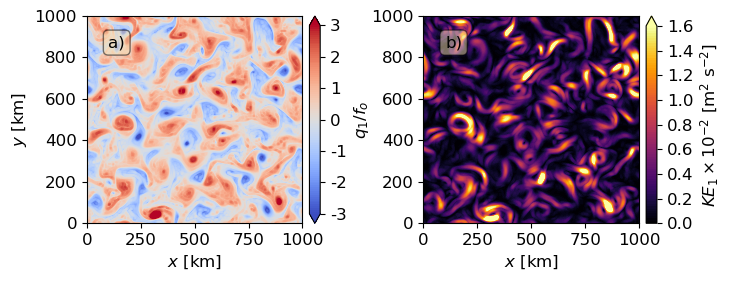

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


ke = 0.5*(eddyrun_lev.u.isel(time=3000)**2 + eddyrun_lev.v.isel(time=3000)**2)
newy, newx = xr.broadcast(eddyrun_lev.y, eddyrun_lev.x)

fontsiz = 12
fo = 1e-5

fig2, ax2 = plt.subplots(1, 2, figsize=(7.5, 3))

cs1 = ax2[0].contourf(newx*1e-3, newy*1e-3, eddyrun_lev.q.isel(lev=0, time=3000)/fo, 
                      np.linspace(-3, 3, 100), cmap='coolwarm', extend='both',
                      vmin=-3, vmax=3)
ax2[0].set_xlabel('$x$ [km]', fontsize=fontsiz)
ax2[0].set_ylabel('$y$ [km]', fontsize=fontsiz)
ax2[0].set_xlim(0, 1000)
ax2[0].set_ylim(0, 1000)
divider = make_axes_locatable(ax2[0])
cax1 = divider.append_axes("right", size="5%", pad=0.07)
col1=fig2.colorbar(cs1, cax=cax1, extend='both')
col1.set_label('$q_1/f_o$', fontsize=fontsiz)
col1.set_ticks(np.arange(-3, 4, 1))
col1.set_ticklabels(np.arange(-3, 4, 1), fontsize=12)
col1.ax.tick_params(labelsize=fontsiz) 
ax2[0].tick_params(axis='both', labelsize=fontsiz)
ax2[0].text(0.1, 0.85, 'a)', fontsize=fontsiz, bbox=props, transform=ax2[0].transAxes)


cs3 = ax2[1].contourf(newx*1e-3, newy*1e-3, ke.isel(lev=0)*1e2, np.arange(0, 1.62, 0.02), 
                         vmin=0, vmax= 1.6, cmap='inferno', extend='max')
ax2[1].set_xlabel('$x$ [km]', fontsize=fontsiz)
ax2[1].set_xlim(0, 1000)
ax2[1].set_ylim(0, 1000)
divider = make_axes_locatable(ax2[1])
cax3 = divider.append_axes("right", size="5%", pad=0.07)
col3 = fig2.colorbar(cs3, cax=cax3)
col3.set_label('$KE_1 \\times 10^{-2}$ [m$^2$ s$^{-2}$]', fontsize=fontsiz)
col3.set_ticks(np.arange(0, 1.8, 0.2))
col3.ax.tick_params(labelsize=fontsiz) 
ax2[1].tick_params(axis='both', labelsize=fontsiz)
ax2[1].text(0.1, 0.85, 'b)', fontsize=fontsiz, bbox=props, transform=ax2[1].transAxes)

fig2.tight_layout(h_pad= 0, w_pad=-0)
fig2.savefig('./FiguresMethodsPaper/fig_QGmodel_KE_q.png', bbox_inches = 'tight', format='png', dpi=500)

### Estimates Rossby number, decorrelation time scale and degrees of freedom

\begin{equation}
    Ro = \frac{\sqrt{D2(r)}}{fr}
\end{equation}


\begin{equation}
    T_{corr} = \frac{r}{\sqrt{D2(r)}}
\end{equation}

\begin{equation}
    N =\frac{T_{corr}}{T_{tot}}
\end{equation}

In [13]:
# Calculates degrees of freedom
nyears = 5
yr2day = 365

Tmax = yr2day*nyears*86400

qg_tscale3 = timescale(mSF_15.du2.mean(dim='time'), 
                       mSF_15.dr.mean(dim='time')).values

qg_dof = Tmax/qg_tscale3

nu3 = np.sqrt(qg_dof)

# First-order structure functions
### First-order structure functions are estimated to test if the simulated flow is homogeneous (i.e., mean flow is $\sim0$)

We calculate

\begin{equation}
    D1(r) = D1_L(r) + D1_T(r) = \langle\delta u_L(\mathbf{s}, \mathbf{r}, t)\rangle + \langle\delta u_T(\mathbf{s}, \mathbf{r}, t)\rangle,
\end{equation}

where $D1(r)$ is the first-order structure function (sum of the longitudinal $D1_L(r)$ and transversal $D1_T(r)$ components), $\mathbf{s}$, $\mathbf{r}$, $t$ are the position vector, the distance vector, and time (days), respectively. $r=|\mathbf{r}|$, and $\langle()\rangle$ indicate ensemble average. 

Here, we also perform an average over all locations $\mathbf{s}$ and orientations $\overline{()}$ to construct daily estimates of $\overline{\delta u1}(r, t)=\overline{\delta u_L(\mathbf{s}, \mathbf{r}, t)} + \overline{\delta u_T(\mathbf{s}, \mathbf{r}, t)}$, which produces Gaussian-distributed quantities per central limit theorem.

#### Calculates PDFs of $\overline{\delta u1}(r,t)$

In [14]:
# First-order structure function
from scipy.stats import norm
from xhistogram.xarray import histogram
from scipy.stats import skew, kurtosis

# First order structure function
sf1_mn = mSF_15.du1.mean(dim='time')
sf1_std = mSF_15.du1.std(dim='time')
rr1 = mSF_15.dr.mean(dim='time')
du1 = mSF_15.du1


in1 = 2
in2 = 5
in3 = 10
in4 = 18

du1r = 0.4

dull_mn = mSF_15.ulls.mean(dim='time')
dutt_mn = mSF_15.utts.mean(dim='time')
dull_std = mSF_15.ulls.std(dim='time')
dutt_std = mSF_15.utts.std(dim='time')


# Bins
d1_bins = np.arange(-3, 3.5, du1r)#np.arange(-1e-2, 1e-2, 6e-5)/sf1_std[in1].values
d2_bins = np.arange(-3, 3.5, du1r)#np.arange(-1e-2, 1e-2, 2e-4)/sf1_std[in2].values
d3_bins = np.arange(-3, 3.5, du1r)#np.arange(-1e-2, 1e-2, 6e-4)/sf1_std[in3].values
d4_bins = np.arange(-3, 3.5, du1r)#np.arange(-1e-2, 1e-2, 1e-3)/sf1_std[in4].values


# Histograms
sf1h0 =  histogram(du1.isel(mid_rbins=in1)/sf1_std[in1], bins=d1_bins, dim=['time'], density=True)
sf1h2 = histogram(du1.isel(mid_rbins=in2)/sf1_std[in2], bins=d2_bins, dim=['time'], density=True)
sf1h10 = histogram(du1.isel(mid_rbins=in3)/sf1_std[in3], bins=d3_bins, dim=['time'], density=True)
sf1h15 = histogram(du1.isel(mid_rbins=in4)/sf1_std[in4], bins=d4_bins, dim=['time'], density=True)

# Constructs Gaussian
sf1p0 = norm.pdf(d1_bins, sf1_mn[in1]/sf1_std[in1], 1)
sf1p2 = norm.pdf(d2_bins, sf1_mn[in2]/sf1_std[in2], 1)
sf1p10 = norm.pdf(d3_bins, sf1_mn[in3]/sf1_std[in3], 1)
sf1p15 = norm.pdf(d4_bins, sf1_mn[in4]/sf1_std[in4], 1)


# Calculates kurtosis
sf1_skew = np.zeros((len(rr1),))
sf1_kurt = sf1_skew*0.

# for ii in tqdm(range(len(rr1))):
with ProgressBar():    
    sf1_skew = skew(du1.values, axis=0, bias=True)
    sf1_kurt = kurtosis(du1.values, axis=0, fisher=True, bias=True)
#     sf1_kurt[ii] = skew(sf1.D1s.isel(rbins=ii).values)

[                                        ] | 0% Completed | 236.05 usERROR! Session/line number was not unique in database. History logging moved to new session 1283
[########################################] | 100% Completed | 101.17 ms
[########################################] | 100% Completed | 100.77 ms


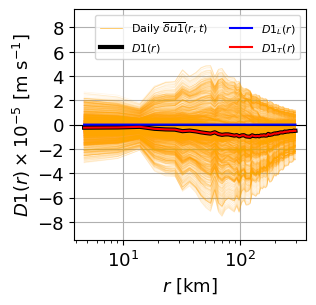

In [16]:
# Plots histograms SF1
colors = plt.cm.jet(np.linspace(0, 1, 4))

fog1 = plt.figure(figsize=(3, 3))

aC = plt.subplot(1, 1, 1)
aC.semilogx(rr1*1e-3, du1.T*1e5, '-', color='orange', 
            linewidth=0.5, alpha=0.1)
aC.axhline(0, color='black', linewidth=0.8, linestyle='-')
aC.semilogx(0, 0, '-', color='orange', linewidth=0.5, alpha=0.8, label='Daily $\\overline{\\delta u1}(r, t)$')
aC.semilogx(rr1*1e-3, sf1_mn*1e5, 'k', linewidth=3, label='$D1(r)$')
aC.fill_between(rr1*1e-3, (sf1_mn + sf1_std/nu3)*1e3, (sf1_mn - sf1_std/nu3)*1e3, 
               alpha=1, color='black', edgecolor=None)
aC.semilogx(rr1*1e-3, dull_mn*1e5, '-b', linewidth=1.5, label='$D1_L(r)$')
aC.fill_between(rr1*1e-3, (dull_mn + dull_std/nu3)*1e3, (dull_mn - dull_std/nu3)*1e3, 
               alpha=1, color='blue', edgecolor=None)
aC.semilogx(rr1*1e-3, dutt_mn*1e5, '-r', linewidth=1.5, label='$D1_T(r)$')
aC.fill_between(rr1*1e-3, (dutt_mn + dutt_std/nu3)*1e3, (dutt_mn - dutt_std/nu3)*1e3, 
               alpha=1, color='red', edgecolor=None)
aC.legend(fontsize=8, loc=1, ncol=2)
aC.set_yticks(np.arange(-10, 12, 2))
aC.set_ylim(-9.5, 9.5)
aC.set_xlabel('$r$ [km]')
aC.set_ylabel('$D1(r) \\times 10^{-5}$ [m s$^{-1}$]')
# aC.set_xticklabels([])
aC.grid()
plt.savefig('./FiguresMethodsPaper/fig_QG_D1.png', bbox_inches = 'tight', format='png', dpi=500)

# Calculates KE spectra usin xrft and self-code

Converts KE spectra to second-order structure function using the relationship:

\begin{align}
D2 = 2\int^\infty_0 E(k)[1 - J_0(ks)]dk
\end{align}

$k$ is in rad per km

In [17]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Computes spectra and SF2 of model run
i1 = -2 - yr2day * nyears
time3y = np.arange(i1, i1 + yr2day * nyears)

# Spectral window in space
ix, jx = eddyrun_lev.u.isel(lev=0, time=0).T.shape

u1 = eddyrun_lev.u.isel(time=time3y, lev=0)
v1 = eddyrun_lev.v.isel(time=time3y, lev=0)

x = eddyrun_lev.x.values
y = eddyrun_lev.y.values

dx = np.mean(np.diff(x, axis=0))
dy = np.mean(np.diff(y, axis=0))

# Calculates expected wavenumber to allocate memory
l1, l2 = ix, jx
df1 = 1. / (l1 * dy)
df2 = 1. / (l2 * dx)
f1Ny = 1. / (2 * dy)
f2Ny = 1. / (2 * dx)

f1 = np.arange(-f1Ny, f1Ny, df1)
f2 = np.arange(-f2Ny, f2Ny, df2)

Eu = np.zeros((len(f1), len(f2), len(u1.time)))
Ev = np.zeros((len(f1), len(f2), len(v1.time)))

# Optimized spec_est2 function (assuming it's heavy on computation)
def compute_spec(ii):
    # Access data once and pass to spec_est2
    u_data = u1.isel(time=ii).values.T
    v_data = v1.isel(time=ii).values.T
    
    result_u = spec_est2(u_data, dy, dx, win=False)
    result_v = spec_est2(v_data, dy, dx, win=False)
    
    Eu_res, l, k, dl, dk, flNy, fkNy = result_u  # Adjust according to actual return values
    Ev_res, l, k, dl, dk, flNy, fkNy = result_v  # Same here
    return Eu_res, Ev_res, k, l, dk, dl

# Use ThreadPoolExecutor to parallelize the loop
with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(compute_spec, range(len(u1.time))), total=len(u1.time)))

# Unpack results into Eu and Ev and extract k, l, dk, dl from the first iteration
for ii, (Eu_res, Ev_res, k, l, dk, dl) in enumerate(results):
    Eu[:, :, ii] = Eu_res
    Ev[:, :, ii] = Ev_res
    
    # Now k, l, dk, dl hold the values from the current iteration (if needed)
    if ii == 0:  # Just save k, l, dk, dl from the first iteration
        k_first, l_first, dk_first, dl_first = k, l, dk, dl

100%|███████████████████████████████████████| 1825/1825 [04:43<00:00,  6.45it/s]


In [18]:
# Converts to isotropic EKE spectrum
EKEspc = 0.5*(Eu + Ev) # KE 2D spectrum
# EKEiso = np.zeros(())

EKEiso, Kiso = Ek2DEkiso(EKEspc, k, l, dk, dl)

/home/mog002/spectralanalysis.py:189: RuntimeWarning: divide by zero encountered in divide
  dtheta = (2*np.pi)/(f.sum())
/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Uses XRTF python library

In [19]:
# Uses xrft to calculate isotropic Power Spectrum Density
import xrft

u0 = u1.chunk({'x': 256, 'y': 256, 'time': 1000})
v0 = v1.chunk({'x': 256, 'y': 256, 'time': 1000})

uiso0 = xrft.isotropic_power_spectrum(u0, dim=['x','y'],
                                      window=None, detrend=None, scaling='density')
viso0 = xrft.isotropic_power_spectrum(v0, dim=['x','y'], 
                                      window=None, detrend=None, scaling='density')

# Removes mean
uiso0_dm = xrft.isotropic_power_spectrum(u0-u0.mean(dim='time'), dim=['x','y'], 
                                         window=None, detrend=None, scaling='density')
viso0_dm = xrft.isotropic_power_spectrum(v0-v0.mean(dim='time'), dim=['x','y'], 
                                         window=None, detrend=None, scaling='density')

with ProgressBar():
    # KE isotropic wavenumber spectrum
    ekeiso0 = .5*(uiso0 + viso0).compute()
    ekeiso0_dm = 0.5*(uiso0_dm + viso0_dm).compute()

[                                        ] | 0% Completed | 103.08 ms

/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)


[########################################] | 100% Completed | 105.60 s
[########################################] | 100% Completed | 13.22 ss


### Converts from $E(k)$ to $D2(r)$

In [20]:
# Converts EKE isotropic spectrum to SF2
rr2 = mSF_15.dr.mean(dim='time').values
sf2_mean = mSF_15.du2.mean(dim='time').values
sf2_std = mSF_15.du2.std(dim='time').values

with ProgressBar():
    sf2_EKEiso = E2SF2(ekeiso0.mean(dim='time').values, ekeiso0.freq_r.values*2*np.pi, 
                       ekeiso0.freq_r.diff(dim='freq_r').mean().values*2*np.pi, rr2)

### Calculates $E(k)$ for hourly averages

Corroborates that E(k) is insesitive to the choice of using daily-averaged fields to hourly snapshots

In [21]:
# Loads the last year of 15-year run outputs at hourly dt
eddy1y = xr.open_dataset('/data/SO3/manuelogv/MethodsKEFlux/QGModelRun1year_1hr.nc', chunks={'time': 1000, 'x': 256, 'y': 256})
u2 = eddy1y.u.isel(lev=0)
v2 = eddy1y.v.isel(lev=0)

# Calculates E(k)
uiso1y = xrft.isotropic_power_spectrum(u2, dim=['x','y'], 
                                       window=None, detrend=None, scaling='density')
viso1y = xrft.isotropic_power_spectrum(v2, dim=['x','y'], 
                                       window=None, detrend=None, scaling='density')

with ProgressBar():
    ekeiso1y = .5*(uiso1y + viso1y).compute()

[                                        ] | 0% Completed | 101.46 ms

/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)


[########################################] | 100% Completed | 14.63 s


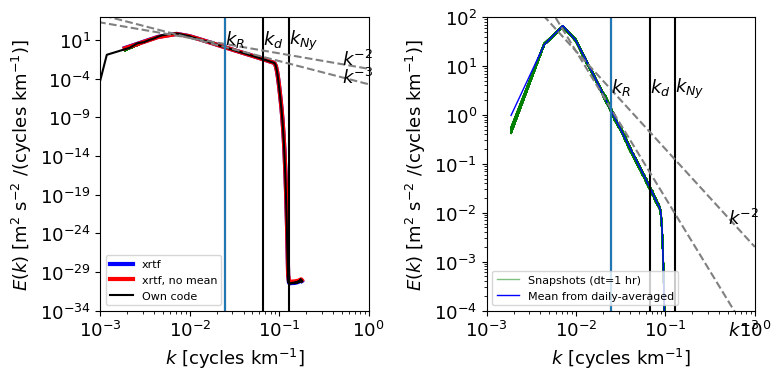

In [22]:
#### Checks that methods are correct
rd = 15e3 #Rossby radius
beta = 1.5e-11
U = 0.025
krh = np.sqrt(beta/U) # Rhines wavenumber
kny = 1/(2*3900) # Nyquist wavenumber

ks = np.array([1.e-4,1])
Es2 = .2e-2*(ks**(-2))
Es3 = .2e-4*(ks**(-3))

fug = plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.loglog(ekeiso1y.freq_r*1e3, ekeiso1y.T, color='green', alpha=0.5, 
           linewidth=0.5)
plt.loglog(ekeiso0.freq_r*1e3, ekeiso0.mean(dim='time'), '-', color='blue', 
           label='xrtf', linewidth=3)
plt.loglog(ekeiso0_dm.freq_r*1e3, ekeiso0_dm.mean(dim='time'), color='red', 
           label='xrtf, no mean', linewidth=3)
plt.loglog(Kiso*1e3, EKEiso, '-k',  label='Own code')
plt.plot(np.ones((2,))*1/rd*1e3, [1e-40, 1e4], '-k')
plt.plot(np.ones((2,))*kny*1e3, [1e-40, 1e4], '-k')
plt.plot(np.ones((2,))*krh*1e3, [1e-40, 1e4], '-k')
plt.plot(ks, Es2, '--', color='gray')
plt.plot(ks, Es3, '--', color='gray')
plt.loglog(krh*np.ones((2,))*1e3, [1e-42, 1e4])
plt.text(5e-1, 6e-3, '$k^{-2}$')
plt.text(5e-1, 3e-5, '$k^{-3}$')
plt.text(kny*1e3, 3, '$k_{Ny}$')
plt.text(1/rd*1e3, 3, '$k_d$')
plt.text(krh*1e3, 3, '$k_{R}$')
plt.ylim(1e-34, 1e4)
plt.xlim(1e-3, 1e0)
plt.legend(fontsize=8)
plt.ylabel('$E(k)$ [m$^2$ s$^{-2}$ /(cycles km$^{-1})$]')
plt.xlabel('$k$ [cycles km$^{-1}$]')

plt.subplot(1, 2, 2)
plt.loglog(ekeiso1y.freq_r*1e3, ekeiso1y.T, color='green', alpha=0.5, 
           linewidth=1)
plt.loglog([], [], color='green', alpha=0.5, label='Snapshots (dt=1 hr)',
           linewidth=1)
plt.loglog(ekeiso0.freq_r*1e3, ekeiso0.mean(dim='time'), '-', color='blue', 
           label='Mean from daily-averaged', linewidth=1)
plt.plot(np.ones((2,))*1/rd*1e3, [1e-40, 1e4], '-k')
plt.plot(np.ones((2,))*kny*1e3, [1e-40, 1e4], '-k')
plt.plot(np.ones((2,))*krh*1e3, [1e-40, 1e4], '-k')
plt.plot(ks, Es2, '--', color='gray')
plt.plot(ks, Es3, '--', color='gray')
plt.loglog(krh*np.ones((2,))*1e3, [1e-42, 1e4])
plt.text(5e-1, 6e-3, '$k^{-2}$')
plt.text(5e-1, 3e-5, '$k^{-3}$')
plt.text(kny*1e3, 3, '$k_{Ny}$')
plt.text(1/rd*1e3, 3, '$k_d$')
plt.text(krh*1e3, 3, '$k_{R}$')
plt.ylim(1e-4, 1e2)
plt.xlim(1e-3, 1e0)
plt.legend(fontsize=8)
plt.ylabel('$E(k)$ [m$^2$ s$^{-2}$ /(cycles km$^{-1})$]')
plt.xlabel('$k$ [cycles km$^{-1}$]')

plt.tight_layout()
# fug.savefig('./FiguresMethodsPaper/figx_spectrum_qg.png', bbox_inches='tight', format='png', dpi=500)

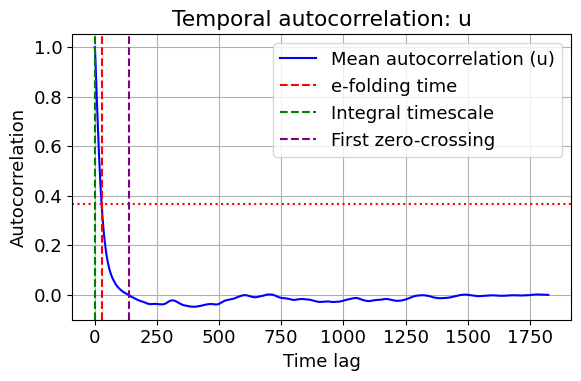

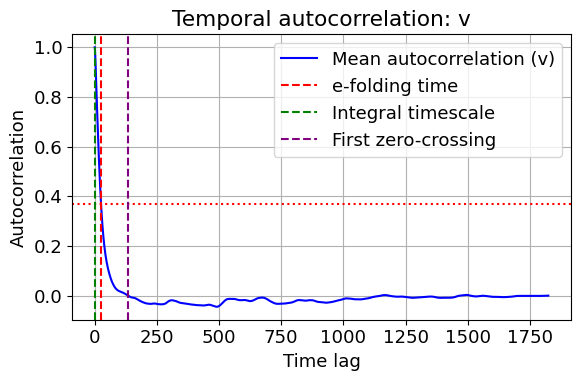

u: e-folding = 28 , integral = 0.499999999999968 , first zero = 137
v: e-folding = 26 , integral = 0.5000000000000231 , first zero = 134


In [23]:
### Decorrelation time scale (daily fields)

# For u-component
R_un, tau_e_un, tau_int_un, tau_zero_un = decorrelation_times(u1, dt=1, plot=True, name='u')

# For v-component
R_vn, tau_e_vn, tau_int_vn, tau_zero_vn = decorrelation_times(v1, dt=1, plot=True, name='v')

print("u: e-folding =", tau_e_un, ", integral =", tau_int_un, ", first zero =", tau_zero_un)
print("v: e-folding =", tau_e_vn, ", integral =", tau_int_vn, ", first zero =", tau_zero_vn)

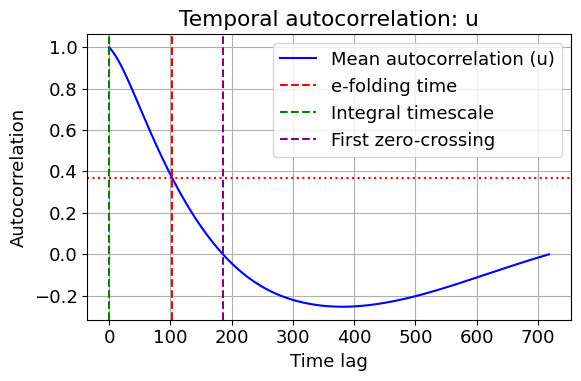

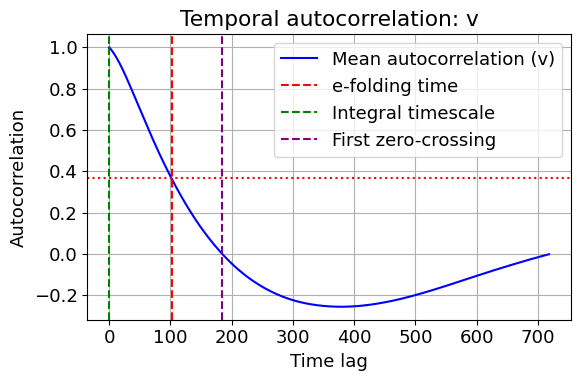

u: e-folding = 103 , integral = 0.49999999999990763 , first zero = 186
v: e-folding = 102 , integral = 0.5000000000000426 , first zero = 185


In [24]:
### Decorrelation time scale (hourly fields)

# For u-component
R_un, tau_e_un, tau_int_un, tau_zero_un = decorrelation_times(u2, dt=1, plot=True, name='u')

# For v-component
R_vn, tau_e_vn, tau_int_vn, tau_zero_vn = decorrelation_times(v2, dt=1, plot=True, name='v')

print("u: e-folding =", tau_e_un, ", integral =", tau_int_un, ", first zero =", tau_zero_un)
print("v: e-folding =", tau_e_vn, ", integral =", tau_int_vn, ", first zero =", tau_zero_vn)

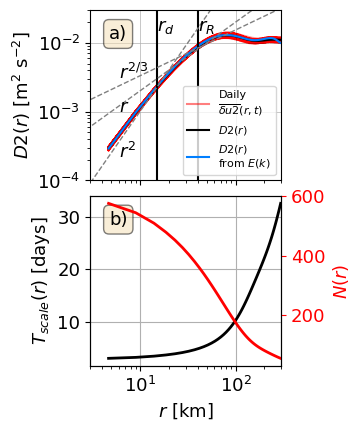

In [257]:
#### Plot
ks = np.array([1.e-4,1])
Es2 = .2e-2*(ks**(-2))
Es3 = .2e-4*(ks**(-3))
Es53 = .2e-1*(ks**(-5/3))

colsfa = '#007FFF'

# Adjusted figure size for 2 subplots
fug = plt.figure(figsize=(3.8, 4.5))

# --------------------------
# Subplot a) 
# --------------------------
plt.subplot(2, 1, 1)
plt.loglog(0, 0, color='r', alpha=0.5, label='Daily\n$\\overline{\\delta u2}(r, t)$')
plt.loglog(rr2*1e-3, mSF_15.du2.values.T, color='r', alpha=0.01)
plt.loglog(rr2*1e-3, sf2_mean, color='k', label='$D2(r)$')
plt.fill_between(rr2*1e-3, sf2_mean + sf2_std/nu3, sf2_mean - sf2_std/nu3, edgecolor=None, 
                 color='k', alpha=0.2)
plt.loglog(rr2*1e-3, sf2_EKEiso*2, color=colsfa, linewidth=1.5, label='$D2(r)$\nfrom $E(k)$')
plt.plot(np.ones((2,))*rd*1e-3, [1e-40, 1e0], '-k')
plt.plot(np.ones((2,))*1e-3/krh, [1e-40, 1e0], '-k')
plt.plot(np.arange(1, 300, 10), np.arange(1, 300, 10)**(2)/(1e5), '--', linewidth=1, color='gray')
plt.plot(np.arange(1, 300, 10), np.arange(1, 300, 10)/5e3, '--', linewidth=1, color='gray')
plt.plot(np.arange(1, 300, 10), np.arange(1, 300, 10)**(2/3)/1.4e3, '--', linewidth=1, color='gray')
plt.text(rd*1e-3, 1.5e-2, '$r_d$')
plt.text(1e-3/krh, 1.5e-2, '$r_R$')
plt.text(6e0, 2.1e-4, '$r^2$')
plt.text(6e0, 1e-3, '$r$')
plt.text(6e0, 3e-3, '$r^{2/3}$')
plt.xlim(3e0, 3e2)
plt.ylim(1e-4, 3e-2)
plt.ylabel('$D2(r)$ [m$^2$ s$^{-2}$]')
plt.gca().set_xticklabels([])
# plt.xlabel('$r$ [km]')
plt.text(0.1, 0.83, 'a)', bbox=props, transform=plt.gca().transAxes)
plt.legend(loc=4, fontsize=8)
plt.grid(linewidth=0.5)

# --------------------------
# Subplot b) 
# --------------------------
s1 = plt.subplot(2, 1, 2)
plt.semilogx(rr2*1e-3, qg_tscale3/86400, '-', color='black', linewidth=2)
plt.xlim(3e0, 3e2)
plt.ylabel('$T_{scale}(r)$ [days]')
plt.xlabel('$r$ [km]')
s1a = plt.twinx(s1)
s1a.semilogx(rr2*1e-3, qg_dof, '-', color='red', linewidth=2)
s1a.set_xlim(3e0, 3e2)
s1a.set_ylabel('$N(r)$', color='red')
s1a.tick_params(axis='y', colors='red')
s1.text(0.1, 0.83, 'b)', bbox=props, transform=plt.gca().transAxes)
s1.grid()

plt.tight_layout(h_pad=-0.2)
fug.savefig('./FiguresMethodsPaper/fig_QG_D2_N.png', bbox_inches='tight', format='png', dpi=500)

# Prior uncertaintity in the third-order structure function

Here, we defined the third-order structure function as an ensemble average of all raw samples over all orientations, positions and time

\begin{equation}
    D3(r) = D3_{LLL}(r) + D3_{LTT}(r)= \langle \delta u_{L}(\mathbf{s},\mathbf{r}, t)[\delta u^2_{L}(\mathbf{s},\mathbf{r}, t) + \delta u^2_{T}(\mathbf{s},\mathbf{r}, t)]\rangle,
\end{equation}


### PDFs from samples of third-order structure function $\delta u3(\mathbf{s}, \mathbf{r}, t)$ for selected $r$ bins

##### Here we defined the raw samples as

\begin{equation}
    \delta u3(\mathbf{s}, \mathbf{r}, t) = \delta u_{L}(\mathbf{s},\mathbf{r}, t)[\delta u^2_{L}(\mathbf{s},\mathbf{r}, t) + \delta u^2_{T}(\mathbf{s},\mathbf{r}, t)]
\end{equation}

Here, PDFs are calculated from the raw samples that are used to calculate $D3(r)$ for selected $r$ bins to show that the probability distribution is non-Gaussian. Gaussian statistics are required to use the regularized least-squares fitting.

In [26]:
# Means and std deviations of 5-year structure functions
# Gets the first 40 index in r
indx = 0
indf = 60

sf3_mn3 = mSF_15.du3.mean(dim='time').values[indx:indf]
sf3_std3 = mSF_15.du3.std(dim='time').values[indx:indf]
du3 = mSF_15.du3.isel(mid_rbins=np.arange(indx, indf))
rr3 = mSF_15.dr.mean(dim='time').values[indx:indf]

In [27]:
# Set the path to the folder containing the .nc files
file_path = '/data/SO3/manuelogv/MethodsKEFlux/rawduLT/SFtest_results.zarr/'

# # Use glob to get a list of all .nc files in the folder
# nc_files = glob.glob(os.path.join(folder_path, '*.nc'))

# allSF = xr.open_mfdataset(nc_files, combine='by_coords', 
#                           chunks={'x': 155, 'y': 155, 'dcorr': 155, 'time': 150})

allSF = xr.open_zarr(file_path, consolidated=True)
# allSF = allSF.sortby('dcorr')
# allSF = allSF.chunk({'XC': 256, 'YC': 256, 'dcorr': 32, 'time': 10})

print(allSF.nbytes/1e9)
allSF

1512.046614184


<xarray.Dataset>
Dimensions:  (XC: 256, YC: 256, dcorr: 2060, time: 200)
Coordinates:
  * XC       (XC) float64 1.953e+03 5.859e+03 9.766e+03 ... 9.941e+05 9.98e+05
  * YC       (YC) float64 1.953e+03 5.859e+03 9.766e+03 ... 9.941e+05 9.98e+05
  * dcorr    (dcorr) float64 9.92e+04 9.851e+04 9.797e+04 ... 9.851e+04 9.92e+04
    lev      int64 ...
  * time     (time) float64 4.642e+08 4.643e+08 ... 4.813e+08 4.814e+08
Data variables:
    dr       (dcorr, XC, YC, time) float64 dask.array<chunksize=(258, 32, 32, 2), meta=np.ndarray>
    du3      (dcorr, XC, YC, time) float64 dask.array<chunksize=(258, 32, 32, 2), meta=np.ndarray>
    dul2     (dcorr, XC, YC, time) float64 dask.array<chunksize=(258, 32, 32, 2), meta=np.ndarray>
    dut2     (dcorr, XC, YC, time) float64 dask.array<chunksize=(258, 32, 32, 2), meta=np.ndarray>
    theta    (dcorr, XC, YC, time) float64 dask.array<chunksize=(258, 32, 32, 2), meta=np.ndarray>
    ulls     (dcorr, XC, YC, time) float64 dask.array<chunksize=(258, 32, 32, 2), meta=np.ndarray>
    utts     (dcorr, XC, YC, time) float64 dask.array<chunksize=(258, 32, 32, 2), meta=np.ndarray>

(1000.0, 200000.0)

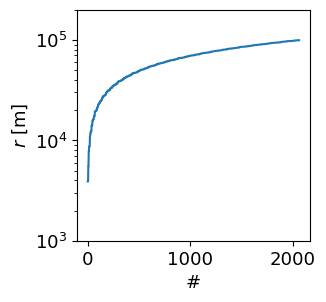

In [28]:
plt.figure(figsize=(3, 3))
plt.semilogy(allSF.dcorr.sortby('dcorr'))
plt.xlabel('#')
plt.ylabel('$r$ [m]')
plt.ylim(1e3, 2e5)

In [29]:
# # Computes third-order statistics
# _, sf3 = SF2_3(allSF1y['ulls'], allSF1y['utts'])


# with ProgressBar():
#     du3 = sf3.compute()

In [30]:
du3raw = allSF.du3.chunk({'time': 50, 'XC': 256, 'YC': 256, 'dcorr': 100}).sortby('dcorr')
print(du3raw)

<xarray.DataArray 'du3' (dcorr: 2060, XC: 256, YC: 256, time: 200)>
dask.array<getitem, shape=(2060, 256, 256, 200), dtype=float64, chunksize=(4, 256, 256, 50), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float64 1.953e+03 5.859e+03 9.766e+03 ... 9.941e+05 9.98e+05
  * YC       (YC) float64 1.953e+03 5.859e+03 9.766e+03 ... 9.941e+05 9.98e+05
  * dcorr    (dcorr) float64 3.891e+03 3.891e+03 ... 9.943e+04 9.943e+04
    lev      int64 ...
  * time     (time) float64 4.642e+08 4.643e+08 ... 4.813e+08 4.814e+08
Attributes:
    long_name:  Third-order velocity fluctuation
    units:      m^3/s^3


/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 67 times more chunks
  return self.array[key]


In [31]:
# Calculates Hovmuller diagrams of probability density for specific $r$ bins
from xhistogram.xarray import histogram
d3h = 0.1 # du3 bin resolution

# mask0 = (du3.dcorr >= 43000) & (du3.dcorr <= 45000)
# mask1 = (du3.dcorr >= 82000) & (du3.dcorr <= 85000)


with ProgressBar():
#     du3_std = allSF1y.du3.isel(dcorr=0).std(dim=('x','y')).compute() # Calculates std deviation at each time step
#     du3_mn = allSF1y.du3.isel(dcorr=0).mean(dim=('x','y')).compute() # Calculates mean
#     du3_nstd = allSF1y.du3.isel(dcorr=0)/du3_std # Normalizes du3 by standard deviation
    
    du3_std0 = du3raw.sel(dcorr=slice(82e3, 85e3)).std(dim=('XC','YC','dcorr')).compute()
    du3_mn0 = du3raw.sel(dcorr=slice(82e3, 85e3)).mean(dim=('XC','YC','dcorr')).compute()
    du3_nstd0 = du3raw.sel(dcorr=slice(82e3, 85e3))/du3_std0
    
    du3_std1 = du3raw.sel(dcorr=slice(43e3, 45e3)).std(dim=('XC','YC','dcorr')).compute()
    du3_mn1 = du3raw.sel(dcorr=slice(43e3, 45e3)).mean(dim=('XC','YC','dcorr')).compute()
    du3_nstd1 = du3raw.sel(dcorr=slice(43e3, 45e3))/du3_std1
    
    # Histograms
#     histD3s1ya = histogram(du3_nstd, bins=np.arange(-80, 80, d3h),
#                            density=True, dim=['x','y']).compute()
    histD3s1yb = histogram(du3_nstd0, bins=np.arange(-80, 80, d3h),
                           density=True, dim=['XC','YC','dcorr']).compute()
    histD3s1yc = histogram(du3_nstd1, bins=np.arange(-80, 80, d3h),
                           density=True, dim=['XC','YC','dcorr']).compute()

[########################################] | 100% Completed | 391.95 s
[########################################] | 100% Completed | 385.17 s
[########################################] | 100% Completed | 276.90 s
[########################################] | 100% Completed | 215.69 s
[########################################] | 100% Completed | 453.68 s
[########################################] | 100% Completed | 194.23 s


In [32]:
# Mean r value
dr3 = allSF.dr.sortby('dcorr')

with ProgressBar():
    dr_mc = dr3.sel(dcorr=slice(43e3, 45e3)).isel(time=0).mean(dim=('XC','YC','dcorr')).compute()
    dr_mb = dr3.sel(dcorr=slice(82e3, 85e3)).isel(time=0).mean(dim=('XC','YC','dcorr')).compute()

/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 164 times more chunks
  return self.array[key]


[########################################] | 100% Completed | 1.62 sms
[########################################] | 100% Completed | 3.47 sms


In [33]:
# Calculates Gaussian distribution from mean and standard deviation
from scipy.stats import norm

tfi = 9
tff = 164

gauss_h1ya = norm.pdf(histD3s1yb.du3_bin, du3_mn0.isel(time=tfi)/du3_std0.isel(time=tfi), 1)
gauss_h1yb = norm.pdf(histD3s1yb.du3_bin, du3_mn0.isel(time=tff)/du3_std0.isel(time=tff), 1)
gauss_h1yc = norm.pdf(histD3s1yc.du3_bin, du3_mn1.isel(time=tfi)/du3_std1.isel(time=tfi), 1)
gauss_h1yd = norm.pdf(histD3s1yc.du3_bin, du3_mn1.isel(time=tff)/du3_std1.isel(time=tff), 1)

/tmp/ipykernel_1135905/3419540283.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=-0.01, h_pad=0.01)


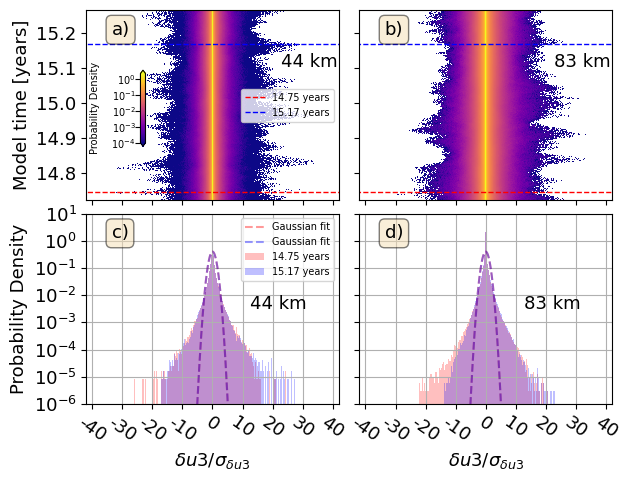

In [34]:
xbins, ybins = np.meshgrid(histD3s1yb.du3_bin, histD3s1yb.time/86400/365)

# Create the figure and axis grid
fig, axs = plt.subplots(2, 2, figsize=(6.5, 5), sharex=True)

# Plot the first row
cax1 = axs[0, 0].pcolormesh(xbins, ybins, histD3s1yc, norm=matplotlib.colors.LogNorm(vmin=1e-4), cmap='plasma')
axs[0, 0].plot([-80, 80], np.ones((2,))*histD3s1yc.time.values[tfi]/86400/365, '--r', linewidth=1,
              label="{:.2f} years".format(histD3s1yc.time[tfi].values/86400/365))
axs[0, 0].plot([-80, 80], np.ones((2,))*histD3s1yc.time.values[tff]/86400/365, '--b', linewidth=1,
              label="{:.2f} years".format(histD3s1yc.time[tff].values/86400/365))
axs[0, 0].set_ylabel('Model time [years]')
axs[0, 0].text(0.1, 0.87, 'a)', bbox=props, transform=axs[0, 0].transAxes)
axs[0, 0].set_xlabel('')
axs[0, 0].set_xticks(np.arange(-50, 60, 10))
axs[0, 0].set_yticks(np.arange(14.7, 15.4, 0.1))
axs[0, 0].set_ylim(histD3s1yc.time[0]/86400/365, histD3s1yc.time[-1]/86400/365)
axs[0, 0].set_xlim(-42, 42)
axs[0, 0].text(0.77, 0.7, "{:.0f} km".format(dr_mc.values*1e-3), transform=axs[0, 0].transAxes)
axs[0,  0].legend(fontsize=7)


# Colorbar
caxi = inset_axes(
    axs[0, 0],
    width="2%",  # width: 50% of parent_bbox width
    height="40%",  # height: 5%
    loc="lower left", borderpad=3,
)
cbi = plt.colorbar(cax1, cax=caxi, orientation="vertical", extend="both")
# Change tick position to top (with the default tick position "bottom", ticks
# overlap the image).
caxi.yaxis.set_ticks_position("left")
cbi.set_ticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
cbi.ax.tick_params(labelsize=7, rotation=0, pad=0)
caxi.set_ylabel('Probability Density', labelpad=-40, fontsize=7)

cax3 = axs[0, 1].pcolormesh(xbins, ybins, histD3s1yb, norm=matplotlib.colors.LogNorm(), cmap='plasma')
axs[0, 1].plot([-80, 80], np.ones((2,))*histD3s1yb.time.values[tfi]/86400/365, '--r', linewidth=1,
              label="{:.2f} years".format(histD3s1yb.time[tfi].values/86400/365))
axs[0, 1].plot([-80, 80], np.ones((2,))*histD3s1yb.time.values[tff]/86400/365, '--b', linewidth=1,
              label="{:.2f} years".format(histD3s1yb.time[tff].values/86400/365))
axs[0, 1].set_yticklabels([])  # Remove y-tick labels for this plot
axs[0, 1].set_xticklabels([])  # Remove x-tick labels for this plot
axs[0, 1].text(0.1, 0.87, 'b)', bbox=props, transform=axs[0, 1].transAxes)
axs[0, 1].set_xlabel('')
axs[0, 1].set_ylabel('')
axs[0, 1].set_xticks(np.arange(-50, 60, 10))
axs[0, 1].set_yticks(np.arange(14.7, 15.4, 0.1))
axs[0, 1].set_ylim(histD3s1yc.time[0]/86400/365, histD3s1yc.time[-1]/86400/365)
axs[0, 1].set_xlim(-42, 42)
axs[0, 1].text(0.77, 0.7, "{:.0f} km".format(dr_mb.values*1e-3), transform=axs[0, 1].transAxes)


# Plot the second row
# (2, 1)
axs[1, 0].bar(histD3s1yc.du3_bin, histD3s1yc.isel(time=tfi), width=d3h, color='red', alpha=0.25,
              label="{:.2f} years".format(histD3s1yc.time[tfi].values/86400/365))
axs[1, 0].bar(histD3s1yc.du3_bin, histD3s1yc.isel(time=tff), width=d3h, color='blue', alpha=0.25,
              label="{:.2f} years".format(histD3s1yc.time[tff].values/86400/365))
axs[1, 0].plot(histD3s1yc.du3_bin, gauss_h1yc, '--', color='red', alpha=0.4,
              label="Gaussian fit")
axs[1, 0].plot(histD3s1yc.du3_bin, gauss_h1yd, '--', color='blue', alpha=0.4,
              label="Gaussian fit")
axs[1, 0].set_xlabel('$\\delta u3/\\sigma_{\\delta u3}$')
axs[1, 0].set_yscale('log')
axs[1, 0].text(0.1, 0.87, 'c)', bbox=props, transform=axs[1, 0].transAxes)
axs[1, 0].set_xticks(np.arange(-50, 60, 10))
axs[1, 0].set_xticklabels(axs[1, 0].get_xticks(), rotation=-35)
axs[1, 0].set_ylabel('Probability Density')
axs[1, 0].set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1])
axs[1, 0].set_xlim(-42, 42)
axs[1, 0].set_ylim(1e-6, 1e1)
axs[1, 0].text(0.65, 0.5, "{:.0f} km".format(dr_mc.values*1e-3), transform=axs[1, 0].transAxes)
axs[1, 0].legend(fontsize=7)
axs[1, 0].grid()

# (2, 3)
axs[1, 1].bar(histD3s1yb.du3_bin, histD3s1yb.isel(time=tfi), width=d3h, color='red', alpha=0.25)
axs[1, 1].bar(histD3s1yb.du3_bin, histD3s1yb.isel(time=tff), width=d3h, color='blue', alpha=0.25)
axs[1, 1].plot(histD3s1yb.du3_bin, gauss_h1ya, '--', color='red', alpha=0.4,
              label="Gaussian fit")
axs[1, 1].plot(histD3s1yb.du3_bin, gauss_h1yb, '--', color='blue', alpha=0.4,
              label="Gaussian fit")
axs[1, 1].set_yscale('log')
axs[1, 1].set_xlabel('$\\delta u3/\\sigma_{\\delta u3}$')
axs[1, 1].text(0.1, 0.87, 'd)', bbox=props, transform=axs[1, 1].transAxes)
axs[1, 1].set_xticks(np.arange(-50, 60, 10))
axs[1, 1].set_xticklabels(axs[1, 1].get_xticks(), rotation=-35)
axs[1, 1].set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1])
axs[1, 1].set_yticklabels([])  # Remove y-tick labels for this plot
axs[1, 1].set_xlim(-42, 42)
axs[1, 1].set_ylim(1e-6, 1e1)
axs[1, 1].text(0.65, 0.5, "{:.0f} km".format(dr_mb.values*1e-3), transform=axs[1, 1].transAxes)
axs[1, 1].grid()

# Adjust layout to avoid overlap
plt.tight_layout(w_pad=-0.01, h_pad=0.01)
plt.savefig('./FiguresMethodsPaper/fig_qg_du3hist_raw_N.png', bbox_inches='tight', format='png', dpi=500)

### Alternative approach for uncertainty

Clearly, the raw samples $\delta u3(\mathbf{s}, \mathbf{r}, t)$ are not Gaussian-distributed. Therefore, we must look for an alternative approach to estimate the prior uncertainty in $D3(r)$.

We average $\delta u3(\mathbf{s}, \mathbf{r}, t)$ over all orientations and positions $\mathbf{s}$ per time step to calculate $\overline{\delta u3}(r, t)$, where the $\overline{()}$ indicates spatial average. Per central limit theorem, we expect that the averaged samples are Gaussian distributed.

In [35]:
# Selected indexes
o0 = 2
o1 = 5
o2 = 12
o3 = 25

drh = 0.55

# Histograms
d3s_bin0 = np.arange(-12, 12, drh)#np.arange(-1e-3, 1e-3, 1e-6)/sf3_std3[o0]
d3s_bin1 = np.arange(-12, 12, drh)#np.arange(-1e-4, 1e-4, 3e-6)/sf3_std3[o1]
d3s_bin2 = np.arange(-12, 12, drh)#np.arange(-1e-3, 1e-3, 2e-5)/sf3_std3[o2]
d3s_bin3 = np.arange(-12, 12, drh)#np.arange(-1e-3, 1e-3, 1e-5)/sf3_std3[o3]

gh0 = histogram(du3.isel(mid_rbins=o0)/sf3_std3[o0], bins=d3s_bin0, density=True)
gh2 = histogram(du3.isel(mid_rbins=o1)/sf3_std3[o1], bins=d3s_bin1, density=True)
gh10 = histogram(du3.isel(mid_rbins=o2)/sf3_std3[o2], bins=d3s_bin2, density=True)
gh20 = histogram(du3.isel(mid_rbins=o3)/sf3_std3[o3], bins=d3s_bin3, density=True)

# Constructs Gaussian
g0 = norm.pdf(d3s_bin0, sf3_mn3[o0]/sf3_std3[o0], 1)
g2 = norm.pdf(d3s_bin1, sf3_mn3[o1]/sf3_std3[o1], 1)
g10 = norm.pdf(d3s_bin2, sf3_mn3[o2]/sf3_std3[o2], 1)
g20 = norm.pdf(d3s_bin3, sf3_mn3[o3]/sf3_std3[o3], 1)

In [36]:
# Calculates Kurtosis and Skewness
sf3_skew = skew(du3.values, axis=0, bias=True)
sf3_kurt = kurtosis(du3.values, axis=0, fisher=True, bias=True)

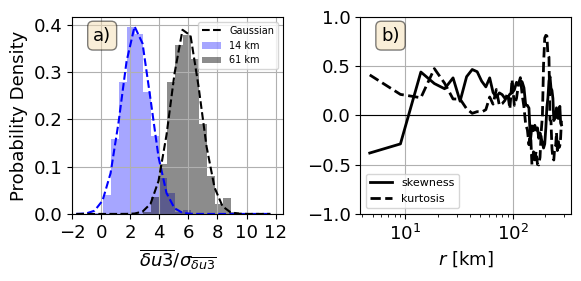

In [37]:
# Plots histograms
colors = plt.cm.jet(np.linspace(0, 1, 4))

fog0 = plt.figure(figsize=(6, 3))
a0a = plt.subplot(1, 2, 1)
plt.bar(gh0.du3_bin, gh0, width=drh, label="{:2.0f} km".format(rr1.values[o0]*1e-3), 
        color='b', edgecolor=None, alpha=0.35)
plt.plot(d3s_bin0, g0, '--', color='blue')
plt.bar(gh10.du3_bin, gh10, width=drh, label="{:2.0f} km".format(rr1.values[o2]*1e-3), 
        color='k', edgecolor=None, alpha=0.45)
plt.plot(d3s_bin2, g10, '--', color='black', label='Gaussian')
plt.legend(fontsize=7, loc=1)
plt.xlim(-2, 12.5)
a0a.set_xticks(np.arange(-2, 14, 2))
a0a.set_ylabel('Probability Density')
a0a.set_xlabel('$\\overline{\\delta u3}/\\sigma_{\\overline{\\delta u3}}$')
a0a.text(0.1, 0.88, 'a)', bbox=props, transform=a0a.transAxes)
a0a.grid()


a0b = plt.subplot(1, 2, 2)
a0b.semilogx(rr3*1e-3, sf3_skew, '-k', linewidth=2, label='skewness')
a0b.semilogx(rr3*1e-3, sf3_kurt, '--k', linewidth=2, label='kurtosis')
a0b.axhline(0, color='black', linewidth=0.8, linestyle='-')
a0b.set_yticks(np.arange(-1.5, 2, 0.5))
a0b.set_ylim(-1, 1)
a0b.legend(fontsize=8)
a0b.set_xlabel('$r$ [km]')
a0b.text(0.1, 0.88, 'b)', bbox=props, transform=a0b.transAxes)
a0b.grid()


fog0.tight_layout()
plt.savefig('./FiguresMethodsPaper/fig_QG_hist_du3_N.png', bbox_inches = 'tight', format='png', dpi=500)

# KE transfers (fluxes)

First, we calculate the spectral fluxes as:

\begin{equation}
    D3(r)= 2\epsilon_u r - \sum^{N_k}_{j=1} 4\frac{\epsilon_j}{k_j}J_1(k_fr)dk_j
\end{equation}

using the regularized least-squares: 

\begin{equation}
    \hat{\mathbf{x}} = \big(\mathbf{H}^\text{T} \mathbf{W}^{-1} \mathbf{H} + \mathbf{P}^{-1}\big)^{-1} \mathbf{H}^\text{T} \mathbf{W}^{-1} \mathbf{y}
\end{equation}


We compare the cross-scale KE transfers using the structure-function method and regularized least-squares with those estimated using the spectral method (Ayaji et al. 2020):

\begin{align}
F_\Pi(k) = -\int^{k_1}_{k_2}\text{Re}\big[\hat{\mathbf{u}}^\ast\cdot\widehat{(\mathbf{u}\cdot\nabla_{H}\mathbf{u})}\big]dk
\end{align}

In [38]:
# # Spectral fluxes following Ayaji using 5 years only
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

wind = 0  # no windowing
detr = 0  # no detrend

# Assuming eddyrun_lev is a preloaded xarray dataset
un = u1.chunk({'time': 100, 'x': 256, 'y': 256})
vn = v1.chunk({'time': 100, 'x': 256, 'y': 256})

Nx, Ny = un.isel(time=0).shape

dx = np.mean(np.diff(x, axis=0))
dy = np.mean(np.diff(y, axis=0))

# Defines wavenumbers
kx = np.fft.fftfreq(Nx, dx)
ky = np.fft.fftfreq(Ny, dy)
Kmax = max(kx.max(), ky.max())
kk, ll = np.meshgrid(kx, ky)
K2D = np.sqrt(kk**2 + ll**2)
ddk = 1./(dx*Nx)
ddl = 1./(dy*Ny)
dK0 = max(ddk, ddl)
K1D0 = dK0*np.arange(1, int(Kmax/dK0))

# Calculates spectral flux
Nk = len(K1D0)
Nt = len(un.time)

# flux = np.zeros((Nt, Nk))

# Convert xarray to numpy once
un_np = un.values
vn_np = vn.values

def calculate_flux(ii):
    return spectralFlux(un_np[ii, :, :], vn_np[ii, :, :], x, y, wind, detr)

with ProcessPoolExecutor() as executor:
    results = list(tqdm(executor.map(calculate_flux, range(Nt)), total=Nt))

# Unpack results from ProcessPoolExecutor
K1D_list = []
specflux_list = []
divFlux_list = []

for K1D_i, specflux_i, divFlux_i in results:
    K1D_list.append(K1D_i)
    specflux_list.append(specflux_i)
    divFlux_list.append(divFlux_i)

# Convert to arrays
specflux_arr = np.vstack(specflux_list)    # shape: (Nt, Nk)
divFlux_arr   = np.vstack(divFlux_list)    # shape: (Nt, Nk)

# K1D should be identical for all times
K1D = K1D_list[0]

# Compute mean and std along time
specFlux_mean = np.mean(specflux_arr, axis=0)
specFlux_std  = np.std(specflux_arr, axis=0)

divFlux_mean = np.mean(divFlux_arr, axis=0)
divFlux_std  = np.std(divFlux_arr, axis=0)

100%|█████████████████████████████████████| 1825/1825 [00:00<00:00, 2015.89it/s]


In [39]:
# km1 = 0.5*(K1D[1:] + K1D[:-1])
# dkm1 = np.mean(np.diff(K1D, axis=0))
# i0f = -32

# dF1_mean = np.mean(np.diff(specflux_arr, axis=1), axis=0)
# dF1_std = np.std(np.diff(specflux_arr, axis=1), axis=0)
# dF1_erru = dF1_mean + dF1_std/nu3[i0f]
# dF1_errl = dF1_mean - dF1_std/nu3[i0f]

### Prior uncertainty in $D3(r)$ and $\epsilon_u$, $\epsilon_j$

For the prior uncertainty in $D3(r)$, we calculate the standard error, i.e., the standard deviation
calculated from $\overline{\delta u3}(r,t)$ divided by the degrees of freedom $N(r)$. We use 
$\overline{\delta u3}(r,t)$ as they are Gaussian distributed. Then, we set the weight matrix $\mathbf{P}$
as a square matrix with the squared standard error as the diagonal entries and zeros elsewhere.

To set the prior uncertainty in $\epsilon_u, \epsilon_j$ we use the L-curve approach, and find the value
that is the best trade-off $\lambda$ between minimizing the missfit $|D3(r) - \widetilde{D3}(r)|$, 
where $\widetilde{D3}(r)$ is the fitted structure function, and the norm two of the
fitted parameters $||\epsilon_j||$. Then, $\mathbf{P}$ is set as a square matrix with $\lambda$ 
(constant) in the diagonal and zeros elsewhere.

In [207]:
# Defines matrixes for 5 years inversion
from scipy.special import jv # Imports Bessel function 

dr3 = np.mean(np.diff(rr3))

# We use the same ones for the spectral method
k3 = K1D*2*np.pi
# k3_nyq = 1/(2*dr3)
# dk3 = 1/max(rr3) 

# k3 = np.arange(dk3, k3_nyq+dk3, dk3)
# dk3 = dk3*np.ones((len(k3)))

# k3 = k3[k3<= 1/(dr3)]
dk3 = np.ones((len(k3),))*np.mean(np.diff(K1D))

nk3 = len(k3)
nr3 = len(rr3)

# Degrees of freedom
year = 86400*365. #seconds
tmax3 = year*nyears # 5 years in seconds

# Define H model matrix
A3 = defA(rr3, k3, dk3)

# Define W weights matrix
wgts3 = sf3_std3/nu3[indx:indf]
W3 = np.diag(wgts3**2)

# Define P covariance matrix
fac = 1e-1
fac_epsj = 1e-10

P3 = np.concatenate(([fac*2], np.ones((nk3, ))*fac_epsj), axis=0)
P3 = np.diag(P3)

In [221]:
# Tests for choosing P matrix
from numpy.linalg import norm

# Define P covariance matrix
fac0 = np.logspace(-15, -1, 80)
po = np.logspace(-15, -1, 80)

norm2_eps = np.zeros((len(po), len(fac0)))
norm2_epsu = np.zeros((len(po), len(fac0)))
norm2_res = np.zeros((len(po), len(fac0)))
norm2_err = np.zeros((len(po), len(fac0)))
norm2_erru = np.zeros((len(po), len(fac0)))
norm2_P0 = np.zeros((len(po), len(fac0)))
# norm2_std = norm(wgts, 2)

for n in range(len(po)):
    for m in range(len(fac0)):
        
        P0_diag = np.concatenate(([fac0[m]], np.ones((nk3, ))*po[n]), axis=0)
        P0_test = np.diag(P0_diag)
    
        eps_test, sf3_test, res_test, cxx_test = RLS(sf3_mn3, W3, P0_test, A3)
        eps_err_test = np.sqrt(np.diag(cxx_test))
    
        norm2_eps[n, m] = norm(eps_test[1:], ord=2)
        norm2_epsu[n, m] = eps_test[0]**2
        norm2_res[n, m] = norm(res_test/wgts3, ord=2)
        norm2_err[n, m] = norm(eps_err_test[1:], ord=2)
        norm2_erru[n, m] = eps_err_test[0]**2
        norm2_P0[n, m] = norm(np.sqrt(P0_diag[1:]), ord=2)
        
# Finds index where fac_epsj == po
idx = np.abs(po - fac_epsj).argmin()

# Get the mantissa and exponent
mantissa, exponent = f"{fac_epsj:.2e}".split("e")
mantissa = float(mantissa)
exponent = int(exponent)

# Create LaTeX string
Pxi_str = f"${mantissa:.0f} \\times 10^{{{exponent}}}$"
print(Pxi_str)

$1 \times 10^{-10}$


In [222]:
#### Calculates Kinetic Energy transfers

from scipy.optimize import nnls

###### Regularized Least-squares
eps3, V3_mn3, res3, cxx3 = RLS(sf3_mn3, W3, P3, A3)
err3 = np.diag(cxx3) # Errors in epsilon 
eps_err_u3 = eps3 + np.sqrt(err3)# Error upper bound
eps_err_l3 = eps3 - np.sqrt(err3)# Error lower 
Herr3 = defH(k3, dk3)
Fk_err3 = np.sqrt(np.diag(errorsFlux(cxx3, Herr3))) #Error energy flux
Fk3 = calcFk(eps3, k3, dk3) # Calculate F(k)

### Calculates $F(k)$ and $\epsilon_j$ using non-negative least-squares (NNLS) fits

NNLS allows only for positve fitted parameters ($\epsilon_j\geq0$), and assumes that $F(k)$ is a purely increasing function of $k$. 

To estimate the NNLS-based five-year mean $\widetilde{D3}(r)$, $\epsilon_u$, $\epsilon_j$, and $F(k)$, we first estimated the fitted structure function $\widetilde{D3}(r)$ by ensemble averaging $\overline{\delta u3}(r,t)$ and inverted it using NNLS. Subsequently, we inverted the daily $\overline{\delta u3}(r,t)$ time series to generate daily estimates used to calculate standard errors. The standard errors in $\widetilde{D3}(r)$, $F(k)$ and $\epsilon_j$ are calculated by estimating the standard deviation divided by $\sqrt{N}$ where $N$ is the degrees of freedom at the largest $r$.

In [210]:
# Non-negative least-squares for the mean
eps_nnls3 = nnls(A3, sf3_mn3)[0]    
V3_nnls3 = np.dot(A3, eps_nnls3) # reconstructed V3
res_nnls3 = V3_nnls3 - sf3_mn3 # residuals

# Calculate energy cascade
Fk_nnls3 = calcFk(eps_nnls3, k3, dk3)    

In [211]:
# Non-negative least-squares for each daily snapshot
sf3_all = du3.values
Ntr = len(mSF_15.time)

eps_nnls_all = np.zeros((Nt, nk3+1))
V3_nnls_all = np.zeros((Nt, nr3))
res_nnls_all = np.zeros((Nt, nr3))
Fk_nnls_all = np.zeros((Nt, nk3))

for ii in tqdm(range(Ntr)):
    eps_nnls_all[ii, :] = nnls(A3, sf3_all[ii, :])[0]    
    V3_nnls_all[ii, :] = np.dot(A3, eps_nnls_all[ii, :]) # reconstructed V3
    res_nnls_all[ii, :] = V3_nnls_all[ii, :] - sf3_all[ii, :] # residuals

    # Calculate energy cascade
    Fk_nnls_all[ii, :] = calcFk(eps_nnls_all[ii, :], k3, dk3)

# Standard deviation
eps_nnls_all_std = np.std(eps_nnls_all, axis=0)
Fk_nnls_all_std = np.std(Fk_nnls_all, axis=0)
V3_nnls_all_std = np.std(V3_nnls_all, axis=0)

eps_nnls3_eu = eps_nnls3[1:] + eps_nnls_all_std[1:]/nu3[-1]
eps_nnls3_el = eps_nnls3[1:] - eps_nnls_all_std[1:]/nu3[-1]
eps_nnls3_el[np.where(eps_nnls3_el<0)] = 0


100%|██████████████████████████████████████| 1825/1825 [00:03<00:00, 457.71it/s]


### Assuming that NNLS will fail to reproduce the full properties of the KE transfers 
### over the entire $r$ range, we fit $D3(r)$ a partial range.

The partial range is $r<60$ km; this is where we expect that $F(k)$ behaves as an increasing function of $k$

In [212]:
# Calculates F(k) using NNLS only for r<50 km
i0n = 0
i0f = -45
r0 = rr3[i0n:i0f]
dr0 = np.nanmean(np.diff(r0))
N3 = nu3[indx:indf]

kf0 = np.arange(1/max(r0), 1/(dr0)+1/max(r0), 1/max(r0))
dk0 = np.diff(kf0)
k0 = kf0[1:]
# k = np.flipud(k)

nk0 = len(k0)
nr0 = len(r0)

# Define model matrix
A0 = defA(r0, k0, dk0)

# Non-negative least-squares fitting
eps_nnls0 = nnls(A0, sf3_mn3[i0n:i0f])[0]    
V3_nnls0 = np.dot(A0, eps_nnls0) # reconstructed V3
res_nnls0 = V3_nnls0 - sf3_mn3[i0n:i0f] # residuals

# Calculate energy cascade
Fk_nnls0 = calcFk(eps_nnls0, k0, dk0)

In [213]:
# Non-negative least-squares for each daily snapshot
sf3_r50 = du3.isel(mid_rbins=np.arange(i0n, nr3+i0f)).values

eps_nnls_r50 = np.zeros((Nt, nk0+1))
V3_nnls_r50 = np.zeros((Nt, nr0))
res_nnls_r50 = np.zeros((Nt, nr0))
Fk_nnls_r50 = np.zeros((Nt, nk0))

print(A0.shape)
print(sf3_r50.shape)

for ii in tqdm(range(Ntr)):
    eps_nnls_r50[ii, :] = nnls(A0, sf3_r50[ii, :])[0]    
    V3_nnls_r50[ii, :] = np.dot(A0, eps_nnls_r50[ii, :]) # reconstructed V3
    res_nnls_r50[ii, :] = V3_nnls_r50[ii, :] - sf3_r50[ii, :] # residuals

    # Calculate energy cascade
    Fk_nnls_r50[ii, :] = calcFk(eps_nnls_r50[ii, :], k0, dk0)

# Standard deviation
eps_nnls_r50_std = np.std(eps_nnls_r50, axis=0)
Fk_nnls_r50_std = np.std(Fk_nnls_r50, axis=0)
V3_nnls_r50_std = np.std(V3_nnls_r50, axis=0)

eps_nnls_r50_eu = (Fk_nnls0 + Fk_nnls_r50_std/nu3[i0f])
eps_nnls_r50_el = (Fk_nnls0 - Fk_nnls_r50_std/nu3[i0f])
eps_nnls_r50_el[np.where(eps_nnls_r50_el<0)] = 0

(15, 16)
(1825, 15)


100%|█████████████████████████████████████| 1825/1825 [00:00<00:00, 3807.08it/s]


### Transforms from $F_\Pi(k)$ to $D3(r)$ using

\begin{equation}
    D3(r) = -4r\int_0^\infty \frac{1}{k}F_\Pi(k)J_2(kr)dk
\end{equation}

In [232]:
# Convert Spectral Flux to SF3 usin the Fourier transform relationship
from joblib import Parallel, delayed

mask = np.isin(K1D*2*np.pi, k3)        # boolean array
indices = np.where(mask)[0]     # indices in K1D

# Parallel call to your existing Fk2SF3
sf3_list = Parallel(n_jobs=8)(
    delayed(Fk2SF3)(specflux_arr[ii, :], (K1D0 - dK0/2)*np.pi*2, dK0*np.pi*2, rr3) for ii in tqdm(range(Nt))
)

# Convert list to array
sf3_spec = np.vstack(sf3_list)


100%|██████████████████████████████████████| 1825/1825 [00:07<00:00, 253.54it/s]


In [242]:
sf3RLS_spec = Fk2SF3(Fk3, k3+dk3/2, dk3, rr3)

In [238]:
# Common plot style props
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# --- Add top axis for panels c) and e) with [km] next to each ticklabel ---
def add_top_axis(ax, k_ticks=np.array([1/1000.0, 1/100.0, 1/10.0, 1.0]), unit='km', fontsize=10):
    ax_top = ax.twiny()
    ax_top.set_xscale('log')
    ax_top.set_xlim(ax.get_xlim())
    ax_top.xaxis.set_label_position('top')
    ax_top.xaxis.tick_top()

    # Tick locations in k-space
    kmin, kmax = ax.get_xlim()
    lo, hi = min(kmin, kmax), max(kmin, kmax)
    k_ticks = k_ticks[(k_ticks >= lo) & (k_ticks <= hi)]
    ax_top.set_xticks(k_ticks)

    # Tick labels with unit next to the value
    scale_labels = []
    for t in k_ticks:
        val = 1.0 / t
        if abs(val - round(val)) < 1e-6:  # if nearly integer
            scale_labels.append(f"{int(round(val))} {unit}")
        else:
            scale_labels.append(f"{val:.2f} {unit}")  # show decimals if needed

    ax_top.set_xticklabels(scale_labels)

    if fontsize is not None:
        ax_top.set_xticklabels(scale_labels, fontsize=fontsize)
    else:
        ax_top.set_xticklabels(scale_labels)
    
    return ax_top

def plot_specflux():
    fig, ax = plt.subplots(1, 3, figsize=(10.5, 3.5))  # 3 panels now
    clr = '#2CA02C'
    
    from scipy.stats import chi2
    
    # --- Confidence intervals for 5-year mean spectrum ---
    M = 13          # estimate number of independent segments (length time series / decorr time scale)
    alpha = 0.05     # 95% CI
    # nu = 2 * M       # degrees of freedom
    k = ekeiso0.freq_r.values * 1e3  # cycles/km
    E_mean = ekeiso0.mean(dim='time').values
    
    CI_lower, CI_upper = spectrum_confidence_interval(E_mean, M=M, alpha=alpha)

    # --- Confidence intervals for 1-month (hourly) mean spectrum ---
    Mh = 3          # estimate number of independent segments (length time series / decorr time scale)
    alpha = 0.05     # 95% CI
    # nu = 2 * M       # degrees of freedom
    kh = ekeiso1y.freq_r.values * 1e3  # cycles/km
    Eh_mean = ekeiso1y.mean(dim='time').values
    
    CIh_lower, CIh_upper = spectrum_confidence_interval(Eh_mean, M=Mh, alpha=alpha)

    ks = np.array([1.e-4,1])
    Es2 = .2e-2*(ks**(-2))
    Es3 = .2e-4*(ks**(-3))
    Es53 = .2e-1*(ks**(-5/3))
    
    # --- Panel 1: KE spectra ---
    ax[0].fill_between(kh, CIh_lower, CIh_upper, color='green', alpha=0.2, edgecolor=None)
    ax[0].loglog(k, ekeiso1y.mean(dim='time'), color='green', linewidth=1, label='1-month mean\n(Hourly)')
    # ax[0].loglog([], [], color='green', alpha=0.5, , linewidth=1)  # for legend
    
    # Plot 5-year mean with confidence intervals
    ax[0].fill_between(k, CI_lower, CI_upper, color=colsfa, alpha=0.2, edgecolor=None)
    ax[0].loglog(k, E_mean, '-', color=colsfa, label='5-year mean', linewidth=2)
    
    # 1-year mean
    # one_year_mean = ekeiso0.isel(time=np.arange(len(ekeiso0.time)-365, len(ekeiso0.time))).mean(dim='time')
    # ax[0].loglog(ekeiso0.freq_r*1e3, one_year_mean, '--', color='gray', label='1-year mean', linewidth=2)
    
    # Reference wavenumbers
    ax[0].plot(np.ones(2) * 1/rd * 1e3, [1e-40, 1e4], '-k')  # k_d
    ax[0].plot(np.ones(2) * krh * 1e3, [1e-40, 1e4], '-k')    # k_R
    
    # Reference slopes
    ax[0].plot(ks, Es2, '--', color='gray', linewidth=1)
    ax[0].plot(ks, Es3, '--', color='gray', linewidth=1)
    ax[0].plot(ks, Es53, '--', color='gray', linewidth=1)
    
    # Slope annotations
    ax[0].text(2e-1, 7e-3, '$k^{-2}$')
    ax[0].text(2e-1, 2e-4, '$k^{-3}$')
    ax[0].text(2e-1, 1e-1, '$k^{-5/3}$')
    
    # Wavenumber labels
    ax[0].text(1/rd*1e3, 30, '$k_d$')
    ax[0].text(krh*1e3, 30, '$k_{R}$')
    
    # Axes limits and labels
    ax[0].set_ylim(1e-4, 1e3)
    ax[0].set_xlim(1e-3, 1e0)
    ax[0].set_ylabel('$E(k)$ [m$^2$ s$^{-2}$/(cycles km$^{-1})$]')
    ax[0].set_xlabel('$k$ [cycles km$^{-1}$]')
    
    # Panel letter
    ax[0].text(0.1, 0.87, 'a)', bbox=props, transform=ax[0].transAxes)
    
    # Legend and grid
    ax[0].legend(loc=3, fontsize=8, handlelength=3)
    ax[0].grid()
    
    
    # --- Panel 2: old ax[0] becomes ax[1] ---
    # ax[1].semilogx((km1-dK0)*1e3*2*np.pi, dF1_mean/dkm1*1e10*dkm1, 'b', label='From $F_\\Pi(k)$')
    # ax[1].fill_between((km1-dK0)*1e3*2*np.pi, dF1_erru/dkm1*1e10*dkm1, dF1_errl/dkm1*1e10*dkm1, 
    #                    facecolor='blue', edgecolor=None, alpha=0.5)
    ax[1].semilogx(K1D*1e3, -divFlux_mean*1e10, colsfa, label='From $F_\\Pi(k)$')
    ax[1].fill_between(K1D*1e3, (-divFlux_mean + divFlux_std/nu3[-1])*1e10, 
                       (-divFlux_mean - divFlux_std/nu3[-1])*1e10, 
                       facecolor=colsfa, edgecolor=None, alpha=0.5)
    ax[1].plot(np.ones((2,))/rd*1e3, [-3.6, 3.6], '-', color='gray')
    ax[1].plot(np.ones((2,))*krh*1e3, [-3.6, 3.6], '-', color='gray')
    ax[1].text(1/rd*1e3, 2.5, '$k_d$')
    ax[1].text(krh*1e3, 2.5, '$k_R$')
    ax[1].axhline(0, color='black', linewidth=0.8, linestyle='-')
    ax[1].set_yticks(np.arange(-4, 5, 1))
    ax[1].set_ylim(-3, 3)
    # ax[1].set_xlim(np.min(k3)*1e3, np.max(k3)*1e3)
    ax[1].set_ylabel('$\\xi_j*dk_j \\times 10^{-10}$ [m$^2$ s$^{-3}$]')
    ax[1].set_xlabel('$k$ [cycles km$^{-1}$]')
    ax[1].text(0.1, 0.87, 'b)', bbox=props, transform=ax[1].transAxes)
    ax[1].text(1e-3, 1.5, 'Injection', fontsize=10)
    ax[1].text(1e-3, -1.5, 'Sink', fontsize=10)
    ax[1].grid()
    ax[1].legend(loc=3, fontsize=8, ncol=2, labelspacing=0.15, handlelength=3)

    
    # --- Panel 3: old ax[1] becomes ax[2] ---
    ax[2].semilogx(K1D*1e3, specFlux_mean*1e10, '-', color=colsfa, label='$F_\\Pi(k)$')
    ax[2].fill_between(K1D*1e3, (specFlux_mean + specFlux_std/nu3[-1])*1e10, 
                       (specFlux_mean - specFlux_std/nu3[-1])*1e10, 
                       facecolor=colsfa, edgecolor=None, alpha=0.5)
    ax[2].plot(np.ones((2,))/rd*1e3, [-7.5, 7.5], '-', color='gray')
    ax[2].plot(np.ones((2,))*krh*1e3, [-7.5, 7.5], '-', color='gray')
    ax[2].text(1/rd*1e3, 5.8, '$k_d$')
    ax[2].text(krh*1e3, 5.8, '$k_R$')
    ax[2].axhline(0, color='black', linewidth=0.8, linestyle='-')
    ax[2].set_yticks(np.arange(-8, 10, 2))
    # ax[2].set_xlim(np.min(k3)*1e3, np.max(k3)*1e3)
    ax[2].set_ylim(-7, 7)
    ax[2].set_ylabel('$F(k) \\times 10^{-10}$ [m$^2$ s$^{-3}$]')
    ax[2].set_xlabel('$k$ [cycles km$^{-1}$]')
    ax[2].text(0.1, 0.87, 'c)', bbox=props, transform=ax[2].transAxes)
    ax[2].text(1e-3, 3, 'Forward', fontsize=10)
    ax[2].text(1e-3, -3, 'Inverse', fontsize=10)
    ax[2].legend(loc=3, fontsize=8, ncol=2, labelspacing=0.15, handlelength=3)
    ax[2].grid()

    k_ticks = np.array([1/1000.0, 1/100.0, 1/10.0, 1.0, 10.0])
    ax_top_a = add_top_axis(ax[0], k_ticks, unit='km')
    ax_top_b = add_top_axis(ax[1], k_ticks, unit='km')
    ax_top_c = add_top_axis(ax[2], k_ticks, unit='km')

    # --- Inset for ax[2] ---
    axins = inset_axes(ax[2], 0.45, 0.45, loc=1, 
                       bbox_to_anchor=(0.65, 0.85),  # upper right corner
                       bbox_transform=ax[2].transAxes)  # relative to ax[2]
    
    # Replot same spectrum inside inset
    axins.semilogx(K1D*1e3, specFlux_mean*1e10, '-', color=colsfa, linewidth=0.5)
    axins.fill_between(
        K1D*1e3,
        (specFlux_mean + specFlux_std/nu3[-1])*1e10,
        (specFlux_mean - specFlux_std/nu3[-1])*1e10,
        facecolor=colsfa, edgecolor=None, alpha=0.5
    )
    axins.axhline(0, color='black', linewidth=0.8, linestyle='-')
    
    # Zoom limits
    axins.set_xlim(1e-1/(2*np.pi), k3.max()*1e3/(2*np.pi))
    axins.set_ylim(-0.1, 0.1)
    
    # Format inset ticks (small + cleaner)
    axins.set_xticks([1e-1/(2*np.pi), 2e-1/(2*np.pi)])
    axins.tick_params(axis='both', which='both', labelbottom=False, labelsize=6)
    

    # Connect zoom region to main plot with dashed box + connectors
    mark_inset(ax[2], axins, loc1=1, loc2=3, fc="none", ec="0.5")
    fig.tight_layout(w_pad=-0.3)
    fig.savefig('./FiguresMethodsPaper/fig_QG_specFlux.png', dpi=500)



def plot_Lcurve():
    fig, axi = plt.subplots(figsize=(3, 3))
    ei = axi.scatter(norm2_eps[:, 6], norm2_res[:, 6], c=po, cmap='cividis', 
                    s=9, norm=matplotlib.colors.LogNorm(vmin=1e-12, vmax=1e-4))
    axi.plot(norm2_eps[idx, 6], norm2_res[idx, 6], 'ob', markerfacecolor=None, linewidth=0.1)
    axi.set_xlabel('$||\\xi_{j}||^2$ [m$^6$ s$^{-6}$]')
    axi.set_ylabel('$||(\\widetilde{D3} - D3)/\\sqrt{diag(\\mathbf{W})}||^2$')

    caxi = inset_axes(
    axi,
    width="50%",  # width: 50% of parent_bbox width
    height="3%",  # height: 5%
    loc="lower left")
    cbi = fig.colorbar(ei, cax=caxi, orientation="horizontal", extend="both")
    caxi.xaxis.set_ticks_position("top")
    cbi.set_ticks([1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
    cbi.ax.tick_params(labelsize=6, rotation=-45, pad=-3)
    caxi.set_xlabel('$\\mathbf{P}_{\\epsilon_j}$ [m$^6$ s$^{-6}$]', labelpad=-40,
                    fontsize=7)
    axi.set_xticks(10.**(np.arange(-10, 0, 1)))
    axi.set_xticklabels(axi.get_xticks(), fontsize=12)
    axi.set_yticklabels(axi.get_yticks().astype(int), fontsize=12)
    axi.set_xscale('log')
    axi.set_xticks(10.**(np.arange(-10, 0, 1)))
    axi.set_ylim(-3, 10)
    axi.set_xlim(1e-5, 0.1e-2)
    
    # Zoomed inset  
    axins = inset_axes(axi, 0.65, 0.85 , loc=2, bbox_to_anchor=(0.35, 0.90),
                       bbox_transform=axi.figure.transFigure) # no zoom
    axins.scatter(norm2_eps[:, 6], norm2_res[:, 6], c=po, cmap='cividis', 
                     s=9, norm=matplotlib.colors.LogNorm(vmin=1e-12, vmax=1e-4))
    axins.plot(norm2_eps[idx, 6], norm2_res[idx, 6], 'ob', markerfacecolor=None, linewidth=0.1)
    axins.set_xlim(2e-4, 4e-4)
    # axins.set_yticklabels(axins.get_yticks(), fontsize=6)
    # axins.set_xticks([])                 # Removes the ticks
    axins.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Hides ticks and labels
    mark_inset(axi, axins, loc1=2, loc2=4, fc="none", ec="0.5")
    axins.annotate(Pxi_str, xy=(norm2_eps[idx, 6], norm2_res[idx, 6]), 
                   xytext=(norm2_eps[idx, 6]-0.3e-4, norm2_res[idx, 6]+0.344),
                   fontsize=8, arrowprops=dict(arrowstyle="-|>, head_width=0.1",mutation_scale=5, fc="k"))
    axins.tick_params(axis='y', labelsize=6)
    axi.set_ylim(-3, 100)
    axins.set_ylim(0, 6)


    fig.tight_layout()
    fig.savefig('./FiguresMethodsPaper/fig_QG_Lcurve.png', dpi=500)

def plot_specflux_RLS():
    fig, ax = plt.subplots(1, 3, figsize=(10.5, 3.5))  # <-- 1x3 layout
    clr = '#2CA02C'
    
    # --- Panel 1: same as before ---
    ax[0].semilogx(rr3*1e-3, du3.T*1e5, color='orange', alpha=0.03, linewidth=0.3)
    ax[0].semilogx(1e0, 0, '-', color='orange', label='$\\overline{\\delta u3}(r, t)$', linewidth=0.3)
    ax[0].semilogx(rr3*1e-3, sf3_mn3*1e5, color='black', label='$D3(r)$', linewidth=4)
    ax[0].fill_between(rr3*1e-3, (sf3_mn3+wgts3)*1e5, (sf3_mn3-wgts3)*1e5, facecolor='orange', alpha=0.5)
    ax[0].semilogx(rr3*1e-3, V3_mn3*1e5, '--', color='red', 
                   linewidth=1.5, label='$\\widetilde{D3}(r)$ RLS')
    ax[0].semilogx(rr3*1e-3, np.mean(sf3_spec, axis=0)*1e5, colsfa, label='From $F_\\Pi(k)$')
    ax[0].fill_between(rr3*1e-3, np.mean(sf3_spec, axis=0) + np.std(sf3_spec, axis=0)/nu3[-1], 
                       np.mean(sf3_spec, axis=0) - np.std(sf3_spec, axis=0)/nu3[-1], color=colsfa, alpha=0.5,
                       edgecolor=None)
    ax[0].plot(np.ones((2,))*rd*1e-3, [-4.3, 4.3], '-', color='gray')
    ax[0].plot(np.ones((2,))*1e-3/krh, [-4.3, 4.3], '-', color='gray')
    ax[0].axhline(0, color='black', linewidth=0.8, linestyle='-')
    ax[0].text(rd*1e-3, 3.5, '$r_d$')
    ax[0].text(1/krh*1e-3, 3.5, '$r_R$')
    ax[0].set_xlim(rr3[0]*1e-3, max(rr3)*1e-3)
    ax[0].set_ylim(-4.3, 4.3)
    ax[0].set_xlabel('$r$ [km]')
    ax[0].set_ylabel('$D3(r) \\times 10^{-5}$ [m$^3$ s$^{-3}$]')
    ax[0].grid()
    ax[0].text(0.1, 0.85, 'a)', bbox=props, transform=ax[0].transAxes)
    ax[0].legend(loc=3, fontsize=7, ncol=2, labelspacing=0.15, handlelength=3)
    
    # --- Panel 2: replaces plt calls with ax[1] ---
    # ax[1].semilogx((km1-dK0)*1e3*2*np.pi, dF1_mean/dkm1*1e10*dkm1, 'b', label='From $F_\\Pi(k)$')
    # ax[1].fill_between((km1-dK0)*1e3*2*np.pi, dF1_erru/dkm1*1e10*dkm1, dF1_errl/dkm1*1e10*dkm1, 
    #                    facecolor='blue', edgecolor=None, alpha=0.5)
    ax[1].semilogx(K1D*1e3, -divFlux_mean*1e10, colsfa, label='From $F_\\Pi(k)$')
    ax[1].fill_between(K1D*1e3, (-divFlux_mean + divFlux_std/nu3[-1])*1e10, 
                       (-divFlux_mean - divFlux_std/nu3[-1])*1e10, 
                       facecolor=colsfa, edgecolor=None, alpha=0.5)
    ax[1].semilogx(k3*1e3/(2*np.pi), eps3[1:]*1e10*dk3, color='r', label='RLS')
    ax[1].fill_between(k3*1e3/(2*np.pi), eps_err_u3[1:]*1e10*dk3, eps_err_l3[1:]*1e10*dk3, facecolor='red', alpha=0.5)
    # ax[1].semilogx(k3*1e3, eps_nnls3[1:]*1e10*dk3, '--', color=clr, label='NNLS')
    # ax[1].fill_between(k3*1e3, eps_nnls3_eu*1e10*dk3, eps_nnls3_el*1e10*dk3, facecolor=clr, alpha=0.3)
    # ax[1].semilogx(k0*1e3, eps_nnls0[1:]*1e10*dk0, '-.', label='NNLS for $r<60$ km', color='#00BFC4', linewidth=3)
    # ax[1].fill_between(k0*1e3, eps_nnls_r50_eu*1e10*dk0, eps_nnls_r50_el*1e10*dk0, facecolor='#8C564B', alpha=0.3)
    ax[1].plot(np.ones((2,))/rd*1e3, [-3.6, 3.6], '-', color='gray')
    ax[1].plot(np.ones((2,))*krh*1e3, [-3.6, 3.6], '-', color='gray')
    ax[1].text(1/rd*1e3, 2.5, '$k_d$')
    ax[1].text(krh*1e3, 2.5, '$k_R$')
    ax[1].axhline(0, color='black', linewidth=0.8, linestyle='-')
    ax[1].set_yticks(np.arange(-4, 5, 1))
    ax[1].set_ylim(-3, 3)
    # ax[1].set_xlim(np.min(k3)*1e3, np.max(k3)*1e3)
    ax[1].set_ylabel('$\\xi_j*dk_j \\times 10^{-10}$ [m$^2$ s$^{-3}$]')
    ax[1].set_xlabel('$k$ [cycles km$^{-1}$]')
    ax[1].text(0.1, 0.85, 'b)', bbox=props, transform=ax[1].transAxes)
    ax[1].text(1e-3, 1.5, 'Injection', fontsize=10)
    ax[1].text(1e-3, -1.5, 'Sink', fontsize=10)
    ax[1].grid()
    ax[1].legend(loc=3, fontsize=8, ncol=2, labelspacing = 0.15, handlelength=3)
    
    # --- Panel 3: old ax[1] becomes ax[2] ---
    ax[2].semilogx(K1D*1e3, specFlux_mean*1e10, '-', color=colsfa, label='$F_\\Pi(k)$')
    ax[2].fill_between(K1D*1e3, (specFlux_mean + specFlux_std/nu3[-1])*1e10, 
                       (specFlux_mean - specFlux_std/nu3[-1])*1e10, 
                       facecolor=colsfa, edgecolor=None, alpha=0.5)
    ax[2].semilogx(k3*1e3/(2*np.pi), Fk3*1e10, '-', color='r', label='RLS')
    ax[2].fill_between(k3*1e3/(2*np.pi), (Fk3 + Fk_err3)*1e10, (Fk3 - Fk_err3)*1e10, 
                     facecolor='red', edgecolor=None, alpha=0.5)
    # ax[2].semilogx(k3*1e3, Fk_nnls3*1e10, '--', color=clr, label='NNLS')
    # ax[2].fill_between(k3*1e3, (Fk_nnls3 + Fk_nnls_all_std/nu3[-1])*1e10,
    #                  (Fk_nnls3 - Fk_nnls_all_std/nu3[-1])*1e10, 
    #                  facecolor=clr, edgecolor=None, alpha=0.3)
    # ax[2].semilogx(k0*1e3, Fk_nnls0*1e10, '-.', label='NNLS for $r<60$ km',
    #             color='#00BFC4', linewidth=3)
    # ax[2].fill_between(k0*1e3, (Fk_nnls0 + Fk_nnls_r50_std/nu3[i0f])*1e10, 
    #                  (Fk_nnls0 - Fk_nnls_r50_std/nu3[i0f])*1e10, 
    #                  facecolor='#8C564B', edgecolor=None, alpha=0.3)
    ax[2].plot(np.ones((2,))/rd*1e3, [-7.5, 7.5], '-', color='gray')
    ax[2].plot(np.ones((2,))*krh*1e3, [-7.5, 7.5], '-', color='gray')
    ax[2].text(1/rd*1e3, 5.8, '$k_d$')
    ax[2].text(krh*1e3, 5.8, '$k_R$')
    ax[2].axhline(0, color='black', linewidth=0.8, linestyle='-')
    ax[2].set_yticks(np.arange(-8, 10, 2))
    # ax[2].set_xlim(np.min(k3)*1e3, np.max(k3)*1e3)
    ax[2].set_ylim(-7, 7)
    ax[2].set_ylabel('$F(k) \\times 10^{-10}$ [m$^2$ s$^{-3}$]')
    ax[2].set_xlabel('$k$ [cycles km$^{-1}$]')
    ax[2].text(0.1, 0.85, 'c)', bbox=props, transform=ax[2].transAxes)
    ax[2].text(1e-3, 3, 'Forward', fontsize=10)
    ax[2].text(1e-3, -3, 'Inverse', fontsize=10)
    ax[2].legend(loc=3, fontsize=8, ncol=2, labelspacing = 0.15, handlelength=3)
    ax[2].grid()

    k_ticks = np.array([1/1000.0, 1/100.0, 1/10.0, 1.0, 10.0])

    ax_top_b = add_top_axis(ax[1], k_ticks, unit='km')
    ax_top_c = add_top_axis(ax[2], k_ticks, unit='km')


    # --- Inset for ax[2] ---
    axins = inset_axes(ax[2], 0.45, 0.45, loc=1, 
                       bbox_to_anchor=(0.65, 0.85),  # upper right corner
                       bbox_transform=ax[2].transAxes)  # relative to ax[2]
    
    # Replot same spectrum inside inset
    axins.semilogx(K1D*1e3, specFlux_mean*1e10, '-', color=colsfa, label='$F_\\Pi(k)$', linewidth=0.5)
    axins.fill_between(K1D*1e3, (specFlux_mean + specFlux_std/nu3[-1])*1e10, 
                       (specFlux_mean - specFlux_std/nu3[-1])*1e10, 
                       facecolor=colsfa, edgecolor=None, alpha=0.5)
    axins.semilogx(k3*1e3/(2*np.pi), Fk3*1e10, '-', color='r', label='RLS')
    axins.fill_between(k3*1e3/(2*np.pi), (Fk3 + Fk_err3)*1e10, (Fk3 - Fk_err3)*1e10, 
                     facecolor='red', edgecolor=None, alpha=0.5)
    axins.axhline(0, color='black', linewidth=0.8, linestyle='-')
    
    # Zoom limits
    axins.set_xlim(1e-1/(2*np.pi), k3.max()*1e3/(2*np.pi))
    axins.set_ylim(-0.1, 0.1)
    
    # Format inset ticks (small + cleaner)
    axins.set_xticks([1e-1/(2*np.pi), 2e-1/(2*np.pi)])
    axins.tick_params(axis='both', which='both', labelbottom=False, labelsize=6)
    

    # Connect zoom region to main plot with dashed box + connectors
    mark_inset(ax[2], axins, loc1=1, loc2=3, fc="none", ec="0.5")
    
    fig.tight_layout()
    fig.savefig('./FiguresMethodsPaper/fig_QG_specFlux_RLS.png', dpi=500)


def plot_specflux_NNLS():
    fig, ax = plt.subplots(1, 3, figsize=(10.5, 3.5))  # <-- 1x3 layout
    clr = '#2CA02C'
    
    # --- Panel 1: same as before ---
    ax[0].semilogx(rr3*1e-3, du3.T*1e5, color='orange', alpha=0.03, linewidth=0.3)
    ax[0].semilogx(1e0, 0, '-', color='orange', label='$\\overline{\\delta u3}(r, t)$', linewidth=0.3)
    ax[0].semilogx(rr3*1e-3, sf3_mn3*1e5, color='black', label='$D3(r)$', linewidth=4)
    ax[0].fill_between(rr3*1e-3, (sf3_mn3+wgts3)*1e5, (sf3_mn3-wgts3)*1e5, facecolor='black', alpha=0.5)
    # ax[0].semilogx(rr3*1e-3, V3_mn3*1e5, ':', color='orange', 
    #                linewidth=3, label='$\\widetilde{D3}(r)$ RLS')
    ax[0].semilogx(rr3*1e-3, V3_nnls3*1e5, '--', linewidth=2, 
                   color='#66c2a5', label='$\\widetilde{D3}(r)$ NNLS')
    ax[0].semilogx(rr3*1e-3, np.mean(sf3_spec, axis=0)*1e5, color=colsfa, label='From $F_\\Pi(k)$')
    ax[0].fill_between(rr3*1e-3, np.mean(sf3_spec, axis=0) + np.std(sf3_spec, axis=0)/nu3[-1], 
                       np.mean(sf3_spec, axis=0) - np.std(sf3_spec, axis=0)/nu3[-1], color=colsfa, alpha=0.5,
                       edgecolor=None)
    ax[0].semilogx(r0*1e-3, V3_nnls0*1e5, '-.', linewidth=2, 
                   color='red', label='$\\widetilde{D3}(r)$ NNLS \n($r<60$ km)')
    ax[0].plot(np.ones((2,))*rd*1e-3, [-4.3, 4.3], '-', color='gray')
    ax[0].plot(np.ones((2,))*1e-3/krh, [-4.3, 4.3], '-', color='gray')
    ax[0].axhline(0, color='black', linewidth=0.8, linestyle='-')
    ax[0].text(rd*1e-3, 3.5, '$r_d$')
    ax[0].text(1/krh*1e-3, 3.5, '$r_R$')
    ax[0].set_xlim(rr3[0]*1e-3, max(rr3)*1e-3)
    ax[0].set_ylim(-4.3, 4.3)
    ax[0].set_xlabel('$r$ [km]')
    ax[0].set_ylabel('$D3(r) \\times 10^{-5}$ [m$^3$ s$^{-3}$]')
    ax[0].grid()
    ax[0].text(0.1, 0.85, 'a)', bbox=props, transform=ax[0].transAxes)
    ax[0].legend(loc=3, fontsize=7, ncol=2, labelspacing=0.15, handlelength=3)
    
    # --- Panel 2: replaces plt calls with ax[1] ---
    # ax[1].semilogx((km1-dK0)*1e3*2*np.pi, dF1_mean/dkm1*1e10*dkm1, 'b', label='From $F_\\Pi(k)$')
    # ax[1].fill_between((km1-dK0)*1e3*2*np.pi, dF1_erru/dkm1*1e10*dkm1, dF1_errl/dkm1*1e10*dkm1, 
    #                    facecolor='blue', edgecolor=None, alpha=0.5)
    ax[1].semilogx(K1D*1e3, -divFlux_mean*1e10, colsfa, label='From $F_\\Pi(k)$')
    ax[1].fill_between(K1D*1e3, (-divFlux_mean + divFlux_std/nu3[-1])*1e10, 
                       (-divFlux_mean - divFlux_std/nu3[-1])*1e10, 
                       facecolor=colsfa, edgecolor=None, alpha=0.5)
    # ax[1].semilogx(k3*1e3, eps3[1:]*1e10*dk3, color='r', label='RLS')
    # ax[1].fill_between(k3*1e3, eps_err_u3[1:]*1e10*dk3, eps_err_l3[1:]*1e10*dk3, facecolor='red', alpha=0.5)
    ax[1].semilogx(k3*1e3/(2*np.pi), eps_nnls3[1:]*1e10*dk3, '--', color='#66c2a5', label='NNLS', linewidth=2)
    ax[1].fill_between(k3*1e3/(2*np.pi), eps_nnls3_eu*1e10*dk3, eps_nnls3_el*1e10*dk3, facecolor='#66c2a5', alpha=0.3)
    ax[1].semilogx(k0*1e3/(2*np.pi), eps_nnls0[1:]*1e10*dk0, '-.', label='NNLS \n($r<60$ km)', color='red', linewidth=2)
    ax[1].fill_between(k0*1e3/(2*np.pi), eps_nnls_r50_eu*1e10*dk0, eps_nnls_r50_el*1e10*dk0, facecolor='red', alpha=0.3)
    ax[1].plot(np.ones((2,))/rd*1e3, [-3.6, 3.6], '-', color='gray')
    ax[1].plot(np.ones((2,))*krh*1e3, [-3.6, 3.6], '-', color='gray')
    ax[1].text(1/rd*1e3, 2.5, '$k_d$')
    ax[1].text(krh*1e3, 2.5, '$k_R$')
    ax[1].axhline(0, color='black', linewidth=0.8, linestyle='-')
    ax[1].set_yticks(np.arange(-4, 5, 1))
    ax[1].set_ylim(-3, 3)
    # ax[1].set_xlim(np.min(k3)*1e3, np.max(k3)*1e3)
    ax[1].set_ylabel('$\\xi_j*dk_j \\times 10^{-10}$ [m$^2$ s$^{-3}$]')
    ax[1].set_xlabel('$k$ [cycles km$^{-1}$]')
    ax[1].text(0.1, 0.85, 'b)', bbox=props, transform=ax[1].transAxes)
    ax[1].text(1e-3, 1.5, 'Injection', fontsize=10)
    ax[1].text(1e-3, -1.5, 'Sink', fontsize=10)
    ax[1].grid()
    ax[1].legend(loc=3, fontsize=8, ncol=2, labelspacing = 0.15, handlelength=3)
    
    # --- Panel 3: old ax[1] becomes ax[2] ---
    ax[2].semilogx(K1D*1e3, specFlux_mean*1e10, '-', color=colsfa, label='$F_\\Pi(k)$')
    ax[2].fill_between(K1D*1e3, (specFlux_mean + specFlux_std/nu3[-1])*1e10, 
                       (specFlux_mean - specFlux_std/nu3[-1])*1e10, 
                       facecolor='blue', edgecolor=None, alpha=0.5)
    # ax[2].semilogx(k3*1e3, Fk3*1e10, '-', color='r', label='RLS')
    # ax[2].fill_between(k3*1e3, (Fk3 + Fk_err3)*1e10, (Fk3 - Fk_err3)*1e10, 
    #                  facecolor='red', edgecolor=None, alpha=0.5)
    ax[2].semilogx(k3*1e3/(2*np.pi), Fk_nnls3*1e10, '--', color='#66c2a5', label='NNLS', linewidth=2)
    ax[2].fill_between(k3*1e3/(2*np.pi), (Fk_nnls3 + Fk_nnls_all_std/nu3[-1])*1e10,
                     (Fk_nnls3 - Fk_nnls_all_std/nu3[-1])*1e10, 
                     facecolor='#66c2a5', edgecolor=None, alpha=0.3)
    ax[2].semilogx(k0*1e3/(2*np.pi), Fk_nnls0*1e10, '-.', label='NNLS \n($r<60$ km)',
                   color='red', linewidth=2)
    ax[2].fill_between(k0*1e3/(2*np.pi), (Fk_nnls0 + Fk_nnls_r50_std/nu3[i0f])*1e10, 
                     (Fk_nnls0 - Fk_nnls_r50_std/nu3[i0f])*1e10, 
                     facecolor='red', edgecolor=None, alpha=0.3)
    ax[2].plot(np.ones((2,))/rd*1e3, [-7.5, 7.5], '-', color='gray')
    ax[2].plot(np.ones((2,))*krh*1e3, [-7.5, 7.5], '-', color='gray')
    ax[2].text(1/rd*1e3, 5.8, '$k_d$')
    ax[2].text(krh*1e3, 5.8, '$k_R$')
    ax[2].axhline(0, color='black', linewidth=0.8, linestyle='-')
    ax[2].set_yticks(np.arange(-8, 10, 2))
    # ax[2].set_xlim(np.min(k3)*1e3, np.max(k3)*1e3)
    ax[2].set_ylim(-7, 7)
    ax[2].set_ylabel('$F(k) \\times 10^{-10}$ [m$^2$ s$^{-3}$]')
    ax[2].set_xlabel('$k$ [cycles km$^{-1}$]')
    ax[2].text(0.1, 0.85, 'c)', bbox=props, transform=ax[2].transAxes)
    ax[2].text(1e-3, 3, 'Forward', fontsize=10)
    ax[2].text(1e-3, -3, 'Inverse', fontsize=10)
    ax[2].legend(loc=3, fontsize=8, ncol=2, labelspacing = 0.15, handlelength=3)
    ax[2].grid()

    
    k_ticks = np.array([1/1000.0, 1/100.0, 1/10.0, 1.0, 10.0])

    ax_top_b = add_top_axis(ax[1], k_ticks, unit='km')
    ax_top_c = add_top_axis(ax[2], k_ticks, unit='km')

    # --- Inset for ax[2] ---
    axins = inset_axes(ax[2], 0.45, 0.45, loc=1, 
                       bbox_to_anchor=(0.65, 0.85),  # upper right corner
                       bbox_transform=ax[2].transAxes)  # relative to ax[2]
    
    # Replot same spectrum inside inset
    axins.semilogx(K1D*1e3, specFlux_mean*1e10, '-', color=colsfa, label='$F_\\Pi(k)$', linewidth=0.5)
    axins.fill_between(K1D*1e3, (specFlux_mean + specFlux_std/nu3[-1])*1e10, 
                       (specFlux_mean - specFlux_std/nu3[-1])*1e10, 
                       facecolor=colsfa, edgecolor=None, alpha=0.5)
    axins.semilogx(k3*1e3/(2*np.pi), Fk_nnls3*1e10, '--', color='#66c2a5', label='NNLS', linewidth=1)
    axins.fill_between(k3*1e3/(2*np.pi), (Fk_nnls3 + Fk_nnls_all_std/nu3[-1])*1e10,
                       (Fk_nnls3 - Fk_nnls_all_std/nu3[-1])*1e10, 
                       facecolor='#66c2a5', edgecolor=None, alpha=0.3)
    axins.semilogx(k0*1e3/(2*np.pi), Fk_nnls0*1e10, '-.', label='NNLS \n($r<60$ km)',
                   color='red', linewidth=0.5)
    axins.fill_between(k0*1e3/(2*np.pi), (Fk_nnls0 + Fk_nnls_r50_std/nu3[i0f])*1e10, 
                       (Fk_nnls0 - Fk_nnls_r50_std/nu3[i0f])*1e10, 
                       facecolor='red', edgecolor=None, alpha=0.3)
    axins.axhline(0, color='black', linewidth=0.8, linestyle='-')
    
    # Zoom limits
    axins.set_xlim(1e-1/(2*np.pi), k3.max()*1e3/(2*np.pi))
    axins.set_ylim(-0.1, 0.1)
    
    # Format inset ticks (small + cleaner)
    axins.set_xticks([1e-1/(2*np.pi), 2e-1/(2*np.pi)])
    axins.tick_params(axis='both', which='both', labelbottom=False, labelsize=6)
    

    # Connect zoom region to main plot with dashed box + connectors
    mark_inset(ax[2], axins, loc1=1, loc2=3, fc="none", ec="0.5")

    fig.tight_layout()
    fig.savefig('./FiguresMethodsPaper/fig_QG_specFlux_NNLS.png', dpi=500)

/tmp/ipykernel_1135905/3663458855.py:189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=-0.3)


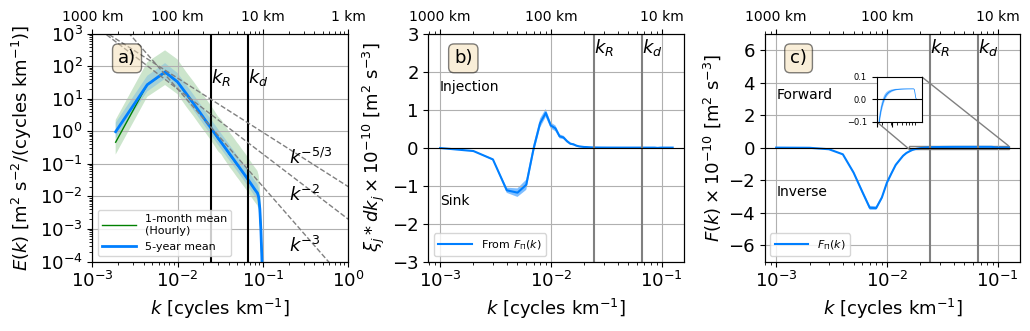

In [226]:
plot_specflux() # Only KE spectruma and fluxes

# Added CI for E(k) using the decorrelation lengthscales calculated above (using zero crossing)

/tmp/ipykernel_1135905/2838500379.py:215: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axi.set_yticklabels(axi.get_yticks().astype(int), fontsize=12)
/tmp/ipykernel_1135905/2838500379.py:240: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


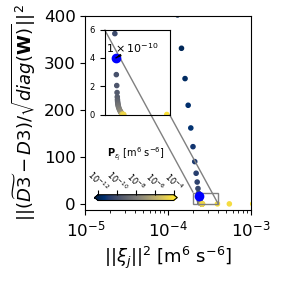

In [236]:
plot_Lcurve() # L curve


/tmp/ipykernel_1135905/3663458855.py:367: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


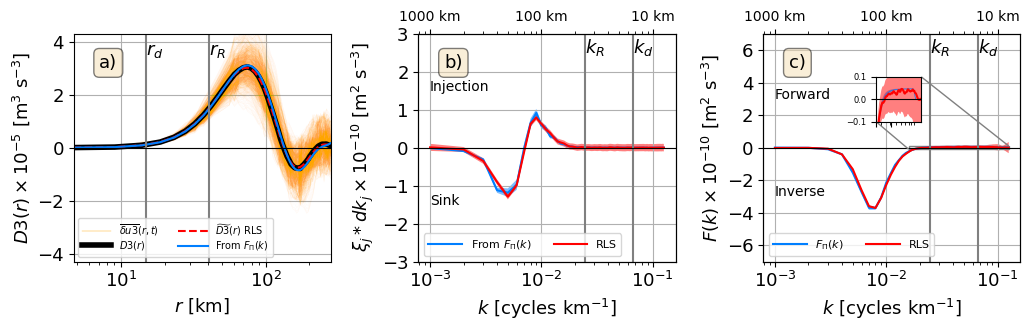

In [233]:
plot_specflux_RLS()# Only RLS

/tmp/ipykernel_1135905/3663458855.py:505: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


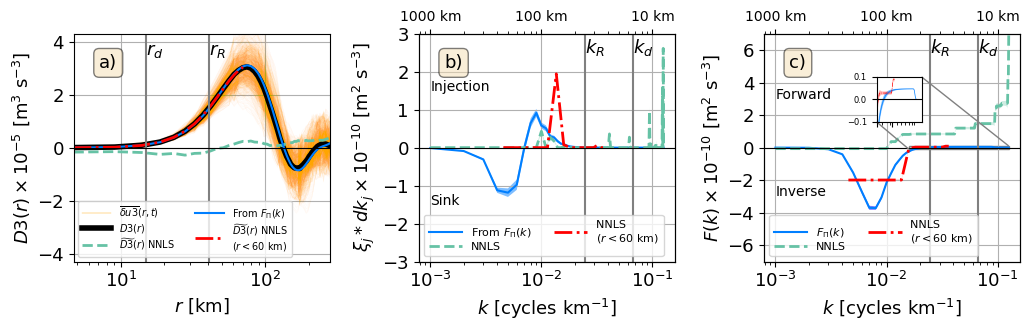

In [234]:
plot_specflux_NNLS()  # Only NNLS